In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import os
import math
import metpy
import datetime
import matplotlib.pyplot as plt 
import scipy.stats as sstats
from scipy.stats.sampling import DiscreteAliasUrn
from matplotlib import cm
import random
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import numpy
%matplotlib inline 
from matplotlib import pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import IPython.display
import json
import sys
import yaml
from random import randrange
import metpy.calc as mpcalc
from metpy.units import units
from functions_gapfill import *
import gstools as gs
import statsmodels.api as sm

# Gapfilling the AWS of the LéXPLORE platform

In this notebook we use the G2S server with Direct Sampling approach (https://gaia-unil.github.io/G2S/briefOverview.html) to fill the data gaps of the meteo station or AWS of the LéXPLORE platform (https://gitlab.renkulab.io/lexplore).

See other notebooks in this repository on how to arrive at this point. 

We use already 1 hourly aggregated values of the meteo station and we fill gaps for the following variables on 1 hour resolution:

* Air temperature

* Baromatric pressure 

* Relative Humidity

* Wind Speed

* Wind Direction

* Wind Gusts (PROBABLY NOT)

* Precipitation

* Solar Incoming Radiation 

* Solar Total Incoming Radation (PROBABLY NOT)

To do so, we use independent data as co-variates, namely variables from the closest gridpoint in ERA5 and ERA5-land. Other potential co-variates could be AWS data from other locations around Lake Geneva or data from other weather models or reconstructions. 

## Activate G2S server

In [2]:
#!pip install G2S libtiff --quiet
from g2s import g2s
g2s('--version')


G2S version 0.98.015, compiled the Dec 17 2022 16:39:25 with Python 3.11.1


In [3]:
#! git clone https://github.com/GAIA-UNIL/G2S.git --quiet

In [4]:
#%%capture
#!export NVFLAGS='-gencode=arch=compute_35,code=sm_35 -gencode=arch=compute_37,code=sm_37 -gencode=arch=compute_50,code=sm_50 -gencode=arch=compute_52,code=sm_52 -gencode=arch=compute_60,code=sm_60 -gencode=arch=compute_61,code=sm_61 -gencode=arch=compute_70,code=sm_70 -gencode=arch=compute_70,code=compute_70'
#!sudo apt -qq install build-essential libzmq3-dev libjsoncpp-dev zlib1g-dev libfftw3-dev libcurl4-openssl-dev -y
#!sudo wget -q "https://raw.githubusercontent.com/zeromq/cppzmq/master/zmq.hpp" -O /usr/include/zmq.hpp
#!( cd G2S/build && make c++ -j --silent)
#!bash G2S/build/c++-build/install_needs_W_VM.sh

In [5]:
!pwd

/home/mwegmann/g2s/notebooks


In [6]:
os.chdir("/home/mwegmann/g2s")

In [7]:
!bash -c "cd G2S/build/c++-build/ && ./server -d"


start daemon


In [8]:
ti = numpy.array(Image.open(BytesIO(requests.get('https://raw.githubusercontent.com/GAIA-UNIL/TrainingImagesTIFF/master/stone.tiff').content)));

In [9]:
a=g2s('-a','echo','-ti',ti,'-dt',[0])

job Id is: 134336966
progress 100.000%      
        

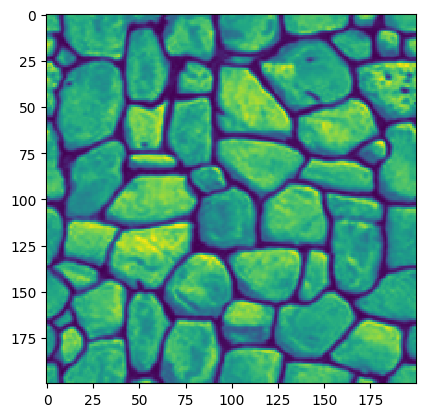

In [10]:
plt.imshow(a[0], interpolation='nearest')

## folder setup

In [182]:
# change yaml location here
with open(r"/home/mwegmann/g2s/notebooks/folder_gap_filling.yaml", "r") as f:
    directories = yaml.load(f, Loader=yaml.FullLoader)

In [183]:
#for d in directories.values():
#    if not os.path.exists(d):
#        os.makedirs(d)

In [184]:
# defining folders
input_folder=directories["g2s_input_folder"]

output_folder=directories["g2s_output_folder"]

plots_folder=directories["g2s_plot_folder"]

recs_folder=directories["g2s_reconstructions_folder"]

scripts_folder=directories["scripts_folder"]

## read in postprocessed input data

check notebooks X and Y to see how this data was created.

### MeteoSwiss Weather station Pully

In [15]:
ms_pully=xr.open_dataset(input_folder+"ms_pully_1hr_g2s.nc")

In [16]:
ms_pully

<xarray.Dataset>
Dimensions:  (time: 26280)
Coordinates:
  * time     (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    rad      (time) float64 ...
    sp       (time) float64 ...
    t2m      (time) float64 ...
    precip   (time) float64 ...
    rh       (time) float64 ...
    sun      (time) float64 ...
    ws       (time) float64 ...
    wd       (time) float64 ...
Attributes:
    description:  For metadata see jupyter notebook get_ms_data_for_gapfill

### MeteoSwiss COSMO 

In [17]:
cosmo=xr.open_dataset(input_folder+"cosmo_1hr_g2s.nc")

In [18]:
cosmo

<xarray.Dataset>
Dimensions:    (time: 26280)
Coordinates:
  * time       (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    T_2M       (time) float64 ...
    RELHUM_2M  (time) float64 ...
    TOT_PREC   (time) float64 ...
    PS         (time) float64 ...
    GLOB       (time) float64 ...
    CLCT       (time) float64 ...
    U          (time) float64 ...
    V          (time) float64 ...

In [19]:
# turning V and U wind components into wind speeds
cosmo_ws=mpcalc.wind_speed(cosmo["U"]* units("m/s"),cosmo["V"]* units("m/s"))
cosmo_ws.name="WS"

In [20]:
# turning V and U wind components into wind direction
cosmo_wd=mpcalc.wind_direction(cosmo["U"]* units("m/s"),cosmo["V"]* units("m/s"))
cosmo_wd.name="WD"

In [21]:
cosmo=xr.merge([cosmo_ws,cosmo_wd,cosmo])

### lexplore Weather station

In [22]:
meteo_orig=xr.open_dataset(input_folder+"meteo_1hr_g2s.nc")

In [23]:
meteo_orig

<xarray.Dataset>
Dimensions:   (time: 26280)
Coordinates:
  * time      (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    AirTC     (time) float64 ...
    RH        (time) float64 ...
    Slrw      (time) float64 ...
    WS        (time) float64 ...
    WindDir   (time) float64 ...
    Rain      (time) float64 ...
    BP        (time) float64 ...
    WindGust  (time) float64 ...

### ERA5

In [24]:
era5=xr.open_dataset(input_folder+"era5_lexplore_g2s.nc")

In [25]:
era5

<xarray.Dataset>
Dimensions:    (time: 26280)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * time       (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    u10        (time) float32 ...
    v10        (time) float32 ...
    t2m        (time) float32 ...
    sp         (time) float32 ...
    ssrd       (time) float32 ...
    tp         (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-05 18:55:56 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [26]:
# turning V and U wind components into wind speeds
era5_ws=mpcalc.wind_speed(era5.u10,era5.v10)
era5_ws.name="ws"

In [27]:
# turning V and U wind components into wind direction
era5_wd=mpcalc.wind_direction(era5.u10,era5.v10)
era5_wd.name="wd"

In [28]:
era5=xr.merge([era5_ws,era5_wd,era5])

### ERA5 land

In [29]:
era5_land=xr.open_dataset(input_folder+"era5_land_lexplore_g2s.nc")

In [30]:
# turning V and U wind components into wind speeds
era5_land_ws=mpcalc.wind_speed(era5_land.u10,era5_land.v10)
era5_land_ws.name="ws"

In [31]:
# turning V and U wind components into wind direction
era5_land_wd=mpcalc.wind_direction(era5_land.u10,era5_land.v10)
era5_land_wd.name="wd"

In [32]:
era5_land=xr.merge([era5_land_ws,era5_land_wd,era5_land])

## define L3 boundaries

In [33]:
time_resolution_hr=1

In [34]:
timestepsinday=24/time_resolution_hr

In [35]:
max_day_gap=5

In [36]:
max_timesteps_tofill=timestepsinday*max_day_gap
max_timesteps_tofill

## Fill Air Temperature Data

### understand the average gap size in data

In [185]:
varname="AirTC"


meteo_orig_airtc has 931 nans in 26280 data points
meteo_orig_airtc has 3.54% missing values
meteo_orig_airtc has 73 gaps with 1.0 median gap size
meteo_orig_airtc has 73 gaps with 12.75 mean gap size


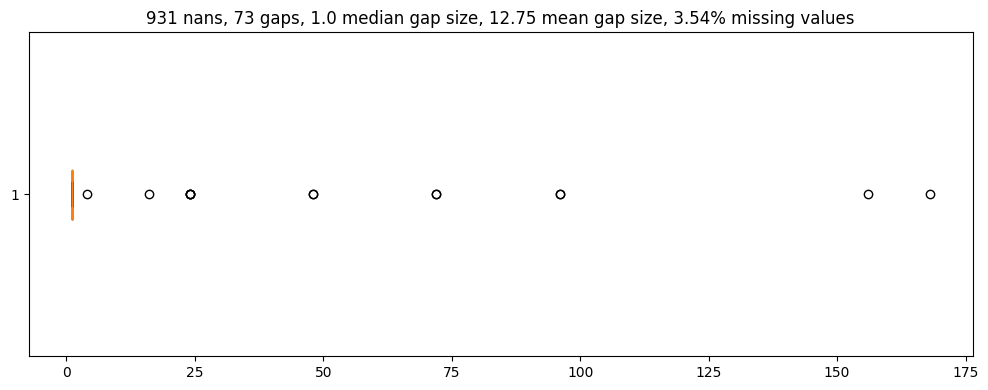

In [186]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_airtc",plot_folder=plots_folder)

### Run gapfilling

The idea is to create gaps that are always at the same position, but different in size.


It is tricky to think about a "perfect gap size" that we should try out. I would suggest that we try out gap sizes from 1 day (24 missing values in the case of the meteo station) towards 4 days (96 missing values in case of the meteo station).

The other question is how many (in %) new missing values do we introduce to evaluate our routine. The meteo station has 3% missing data as it is. Is 10% a good metric to evaluate? 20%?

We have three steps for the reconstruction of each variable:

* Covariate evaluation with N=25, 5% missing data, and [24,48,72] gaps and 10 test runs

* Creating error matrix for error propagation analysis with preferred covariate with N=25, [5,10,15,20] missing data, and [24,48,72,96] gaps and 5 test runs

* Creating the final product/reconstruction with N=50

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
print(datetime.datetime.now())

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="t2m",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2="t2m",cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2="t2m",cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="T_2M",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
error_df

In [39]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")


In [40]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

RUN  MEMBER  PERC     CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE                                                                  
24        5.5    25.0   5.0  0.99848   0.99753     0.99692      0.99537   
48        5.5    25.0   5.0  0.99796   0.99711     0.99547      0.99212   
72        5.5    25.0   5.0  0.99732   0.99664     0.99275      0.98640   

          CORR_quad  CORR_pchip  CORR_subdlin     RMSE  RMSE_lin  RMSE_akima  \
GAP_SIZE                                                                       
24          0.99487     0.99749       0.99860  0.38959   0.49706     0.55307   
48          0.98646     0.99695       0.99812  0.45064   0.53241     0.66827   
72          0.97593     0.99646       0.99754  0.51611   0.57909     0.84335   

          RMSE_spline  RMSE_quad  RMSE_pchip  RMSE_subdlin     STDR  
GAP_SIZE                                                             
24            0.67895    0.71133     0.49994       0.37349  1.01017  
48            0.86904    1.16562     0.54751       0.43124  0.99935  
72            1.16272    1.57201     0.59168       0.49412  0.99830

In [41]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

RUN  MEMBER  PERC     CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE                                                                  
24        5.5    25.0   5.0  0.99900   0.99746     0.99680      0.99564   
48        5.5    25.0   5.0  0.99885   0.99704     0.99509      0.99228   
72        5.5    25.0   5.0  0.99874   0.99683     0.99184      0.98869   

          CORR_quad  CORR_pchip  CORR_subdlin     RMSE  RMSE_lin  RMSE_akima  \
GAP_SIZE                                                                       
24          0.99461     0.99736       0.99866  0.31597   0.50341     0.56427   
48          0.98636     0.99689       0.99811  0.33927   0.54308     0.69562   
72          0.97123     0.99650       0.99784  0.35361   0.56001     0.89749   

          RMSE_spline  RMSE_quad  RMSE_pchip  RMSE_subdlin     STDR  
GAP_SIZE                                                             
24            0.65882    0.72879     0.51232       0.36684  1.00060  
48            0.87458    1.17206     0.55528       0.43321  1.00356  
72            1.03725    1.69720     0.58819       0.45948  1.00317

In [42]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

RUN  MEMBER  PERC     CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE                                                                  
24        5.5    25.0   5.0  0.99891   0.99775     0.99739      0.99585   
48        5.5    25.0   5.0  0.99868   0.99727     0.99531      0.99336   
72        5.5    25.0   5.0  0.99854   0.99704     0.99304      0.98827   

          CORR_quad  CORR_pchip  CORR_subdlin     RMSE  RMSE_lin  RMSE_akima  \
GAP_SIZE                                                                       
24          0.99577     0.99779       0.99872  0.32893   0.47401     0.50861   
48          0.98641     0.99709       0.99826  0.36254   0.52365     0.67695   
72          0.97696     0.99688       0.99773  0.38269   0.54289     0.82843   

          RMSE_spline  RMSE_quad  RMSE_pchip  RMSE_subdlin     STDR  
GAP_SIZE                                                             
24            0.64370    0.64850     0.47099       0.35766  1.00388  
48            0.81109    1.16817     0.53994       0.41366  1.00207  
72            1.07860    1.52398     0.55786       0.47489  0.99885

In [43]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

RUN  MEMBER  PERC     CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE                                                                  
24        5.5    25.0   5.0  0.99884   0.99767     0.99717      0.99609   
48        5.5    25.0   5.0  0.99860   0.99735     0.99603      0.99266   
72        5.5    25.0   5.0  0.99835   0.99697     0.99356      0.98873   

          CORR_quad  CORR_pchip  CORR_subdlin     RMSE  RMSE_lin  RMSE_akima  \
GAP_SIZE                                                                       
24          0.99554     0.99761       0.99861  0.34071   0.48372     0.52711   
48          0.98768     0.99727       0.99817  0.37618   0.51143     0.62866   
72          0.97202     0.99700       0.99781  0.40438   0.54709     0.79549   

          RMSE_spline  RMSE_quad  RMSE_pchip  RMSE_subdlin     STDR  
GAP_SIZE                                                             
24            0.62442    0.66282     0.48662       0.37111  1.00429  
48            0.84903    1.10559     0.52184       0.42626  1.00796  
72            1.05187    1.68566     0.54461       0.46549  1.00536

In [44]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

RUN  MEMBER  PERC     CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE                                                                  
24        5.5    25.0   5.0  0.99819   0.99744     0.99697      0.99566   
48        5.5    25.0   5.0  0.99670   0.99723     0.99545      0.99327   
72        5.5    25.0   5.0  0.99460   0.99687     0.99346      0.98899   

          CORR_quad  CORR_pchip  CORR_subdlin     RMSE  RMSE_lin  RMSE_akima  \
GAP_SIZE                                                                       
24          0.99475     0.99739       0.99862  0.42339   0.50383     0.55020   
48          0.98662     0.99716       0.99829  0.57402   0.52068     0.66794   
72          0.97299     0.99662       0.99814  0.72667   0.55724     0.80297   

          RMSE_spline  RMSE_quad  RMSE_pchip  RMSE_subdlin     STDR  
GAP_SIZE                                                             
24            0.65619    0.71841     0.50998       0.37052  1.00567  
48            0.81026    1.15815     0.52884       0.41193  1.00001  
72            1.03671    1.64082     0.57634       0.43142  0.99900

In [45]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

RUN  MEMBER  PERC     CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE                                                                  
24        5.5    25.0   5.0  0.99808   0.99768     0.99732      0.99582   
48        5.5    25.0   5.0  0.99706   0.99725     0.99527      0.99159   
72        5.5    25.0   5.0  0.99583   0.99673     0.99215      0.98774   

          CORR_quad  CORR_pchip  CORR_subdlin     RMSE  RMSE_lin  RMSE_akima  \
GAP_SIZE                                                                       
24          0.99516     0.99761       0.99859  0.43769   0.48122     0.51685   
48          0.98453     0.99713       0.99815  0.53818   0.52253     0.68519   
72          0.96754     0.99655       0.99772  0.64367   0.57072     0.87366   

          RMSE_spline  RMSE_quad  RMSE_pchip  RMSE_subdlin     STDR  
GAP_SIZE                                                             
24            0.64430    0.68991     0.48641       0.37584  1.00729  
48            0.90890    1.23658     0.53376       0.42996  1.00467  
72            1.10364    1.78651     0.58808       0.47552  1.00537

In [46]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

RUN  MEMBER  PERC     CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE                                                                  
24        5.5    25.0   5.0  0.99804   0.99783     0.99747      0.99605   
48        5.5    25.0   5.0  0.99731   0.99729     0.99523      0.99302   
72        5.5    25.0   5.0  0.99646   0.99679     0.99208      0.98624   

          CORR_quad  CORR_pchip  CORR_subdlin     RMSE  RMSE_lin  RMSE_akima  \
GAP_SIZE                                                                       
24          0.99552     0.99781       0.99858  0.44105   0.46256     0.50027   
48          0.98326     0.99716       0.99819  0.51778   0.51947     0.68613   
72          0.97375     0.99663       0.99796  0.59270   0.56554     0.88282   

          RMSE_spline  RMSE_quad  RMSE_pchip  RMSE_subdlin     STDR  
GAP_SIZE                                                             
24            0.62549    0.66532     0.46619       0.37272  1.00213  
48            0.82692    1.29001     0.53137       0.42288  1.00082  
72            1.16829    1.63479     0.58041       0.44885  1.00067

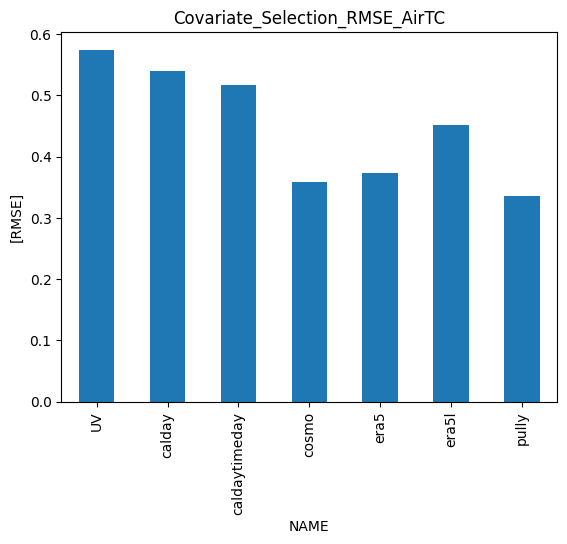

In [68]:
error_df.groupby('NAME').mean().RMSE.plot(kind="bar")
name="Covariate_Selection_RMSE_"+varname
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig(plots_folder+name+".png")

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="t2m",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="t2m",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="t2m",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [134]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [139]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

RUN  MEMBER     CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE PERC                                                            
24       5     3.0    25.0  0.99902   0.99770     0.99730      0.99582   
         10    3.0    25.0  0.99794   0.99554     0.99468      0.99184   
         15    3.0    25.0  0.99688   0.99304     0.99204      0.98780   
48       5     3.0    25.0  0.99884   0.99744     0.99620      0.99370   
         10    3.0    25.0  0.99782   0.99530     0.99232      0.98880   
         15    3.0    25.0  0.99654   0.99180     0.98710      0.98020   
72       5     3.0    25.0  0.99880   0.99700     0.99406      0.99142   
         10    3.0    25.0  0.99764   0.99452     0.98708      0.98280   
         15    3.0    25.0  0.99644   0.99142     0.98082      0.96982   
96       5     3.0    25.0  0.99868   0.99656     0.99170      0.98286   
         10    3.0    25.0  0.99736   0.99296     0.98214      0.96838   
         15    3.0    25.0  0.99610   0.98968     0.97186      0.94788   
120      5     3.0    25.0  0.99874   0.99592     0.98654      0.97454   
         10    3.0    25.0  0.99716   0.99218     0.97232      0.95500   
         15    3.0    25.0  0.99590   0.98936     0.95836      0.92746   
144      5     3.0    25.0  0.99852   0.99588     0.98678      0.96748   
         10    3.0    25.0  0.99730   0.99196     0.95100      0.94490   
         15    3.0    25.0  0.99574   0.98578     0.95522      0.89576   

               CORR_quad  CORR_pchip  CORR_sublin     RMSE  ...  RMSE_sublin  \
GAP_SIZE PERC                                               ...                
24       5       0.99518     0.99768      0.99862  0.31478  ...      0.37064   
         10      0.99124     0.99548      0.99712  0.45232  ...      0.53592   
         15      0.98616     0.99286      0.99570  0.55962  ...      0.65476   
48       5       0.98270     0.99736      0.99822  0.34290  ...      0.42110   
         10      0.97512     0.99506      0.99670  0.46644  ...      0.57200   
         15      0.96362     0.99132      0.99458  0.58802  ...      0.73394   
72       5       0.97438     0.99688      0.99770  0.34296  ...      0.47676   
         10      0.95486     0.99418      0.99548  0.48600  ...      0.67004   
         15      0.92792     0.99084      0.99382  0.59694  ...      0.78462   
96       5       0.94976     0.99644      0.99744  0.36210  ...      0.50358   
         10      0.91282     0.99250      0.99470  0.51568  ...      0.72222   
         15      0.87302     0.98928      0.99280  0.62314  ...      0.84696   
120      5       0.94010     0.99538      0.99690  0.35726  ...      0.55536   
         10      0.86990     0.99180      0.99406  0.53254  ...      0.76698   
         15      0.82272     0.98872      0.99218  0.63800  ...      0.88096   
144      5       0.91628     0.99566      0.99698  0.38362  ...      0.54640   
         10      0.82816     0.99146      0.99416  0.52012  ...      0.76122   
         15      0.74992     0.98568      0.98986  0.65214  ...      1.00554   

               RMSE_VAR_ensmean  RMSE_VAR_ensmed  RMSE_VAR_linear  \
GAP_SIZE PERC                                                       
24       5              0.14916          0.12968          0.25916   
         10             0.20110          0.16916          0.35812   
         15             0.25222          0.20954          0.48528   
48       5              0.17050          0.15284          0.31448   
         10             0.19294          0.16364          0.42754   
         15             0.29230          0.24450          0.58850   
72       5              0.19708          0.17890          0.33346   
         10             0.25928          0.23264          0.47220   
         15             0.32764          0.27702          0.59766   
96       5              0.20630          0.18752          0.35794   
         10             0.26846          0.23946          0.52338   
         15             0.32902     

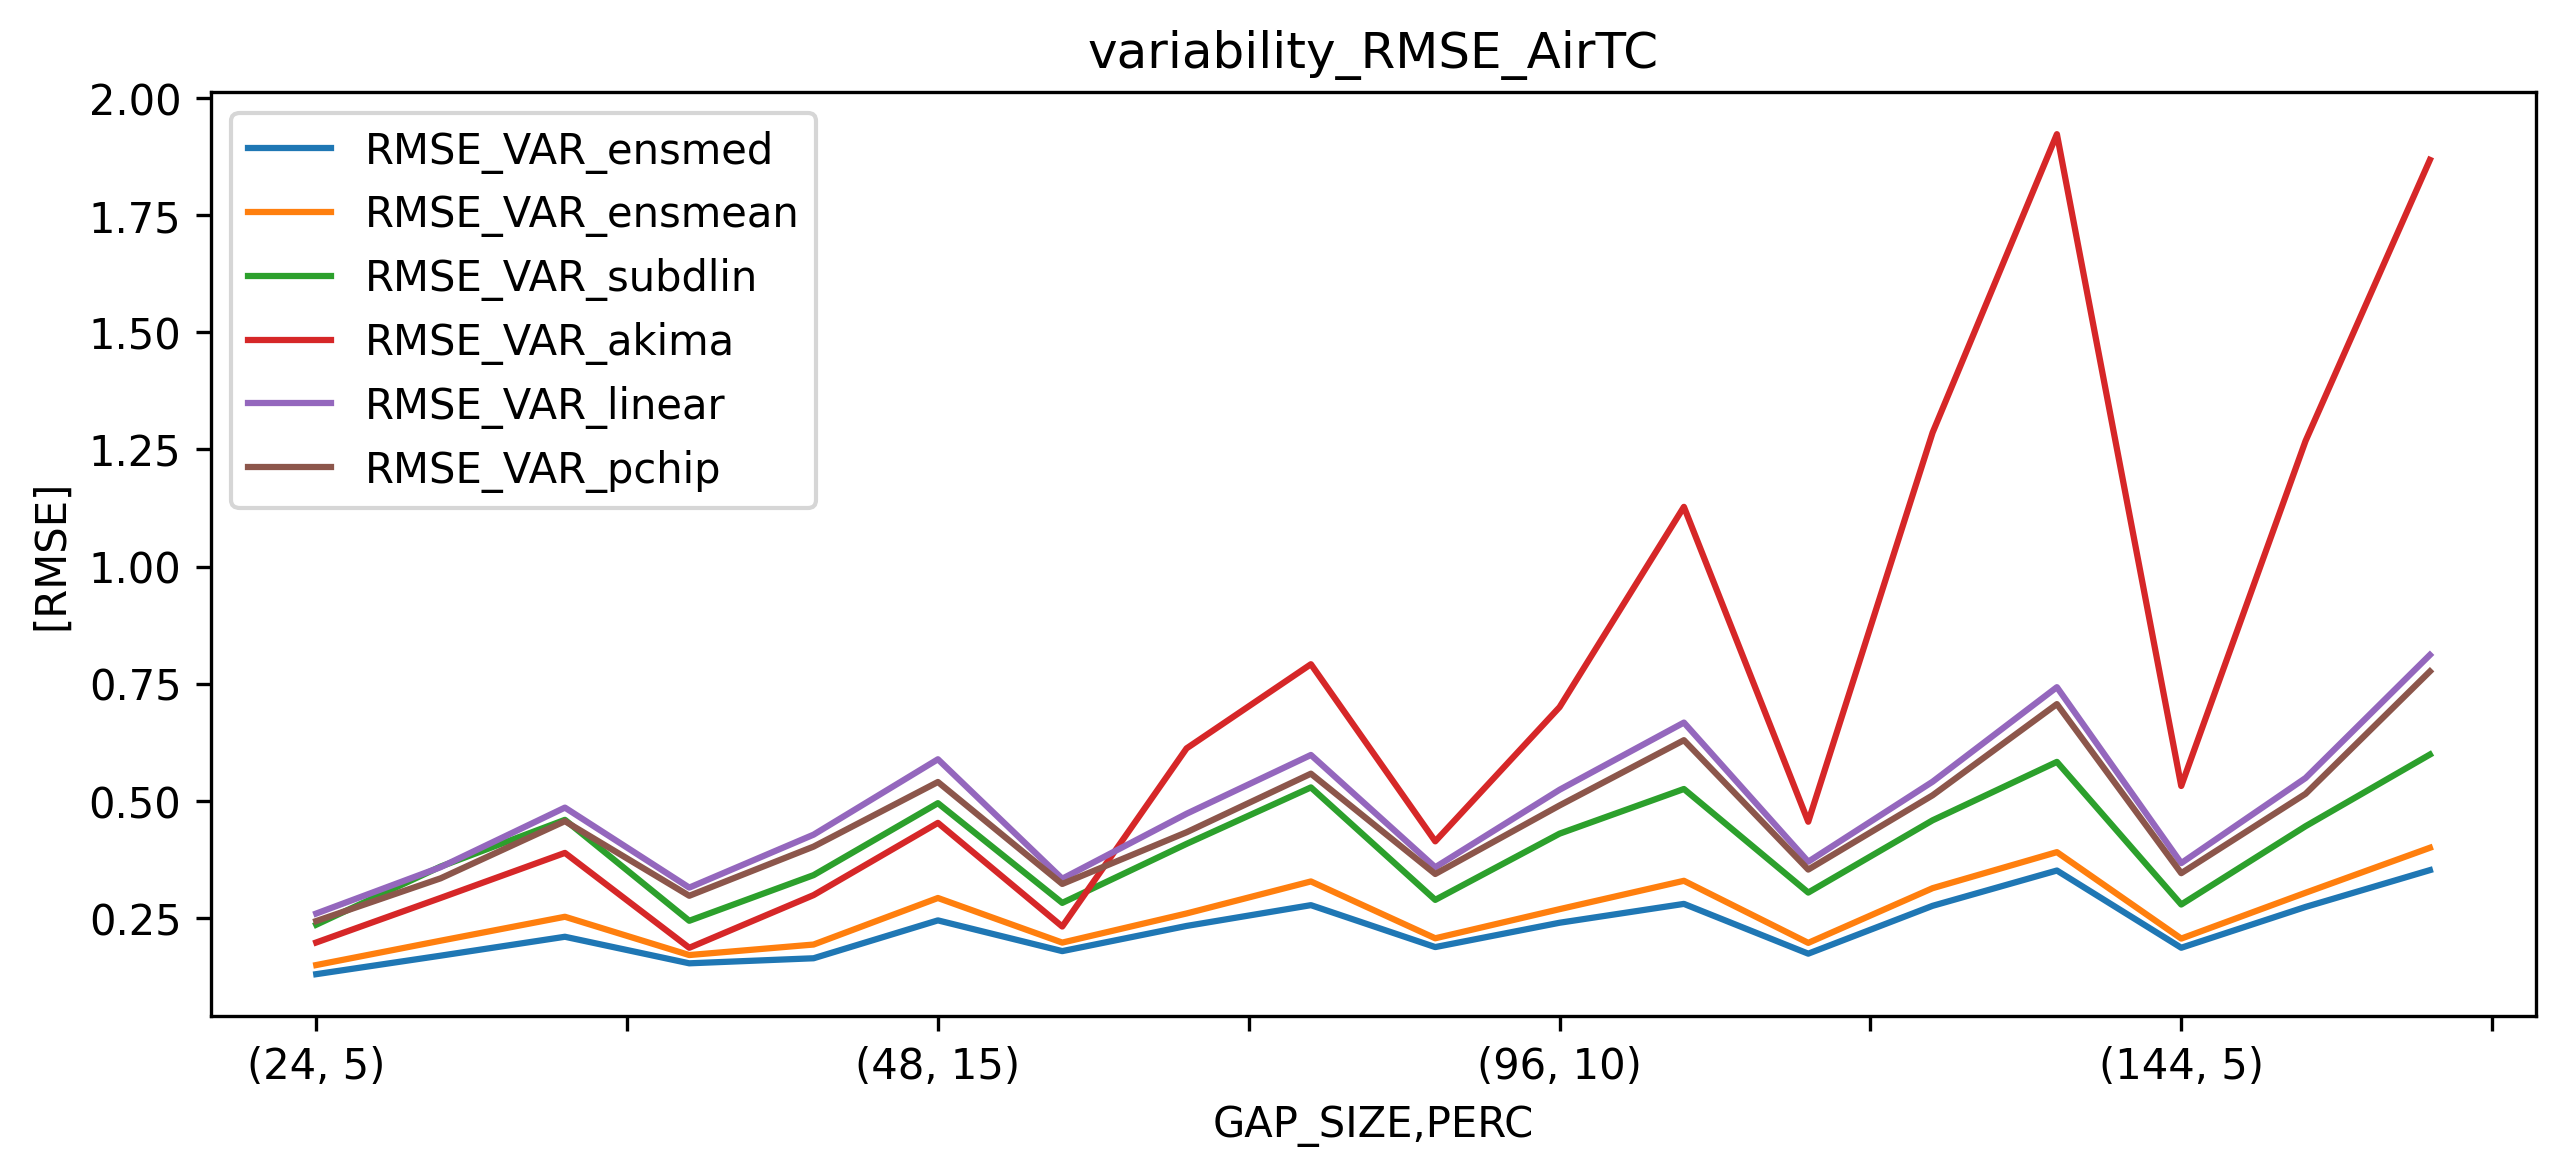

In [143]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_ensmed.plot(label="RMSE_VAR_ensmed")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_ensmean.plot(label="RMSE_VAR_ensmean")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_subdlin.plot(label="RMSE_VAR_subdlin")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_akima.plot(label="RMSE_VAR_akima")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_linear.plot(label="RMSE_VAR_linear")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_VAR_pchip.plot(label="RMSE_VAR_pchip")

plt.legend()
name="variability_RMSE_"+varname
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig(plots_folder+name+".png")

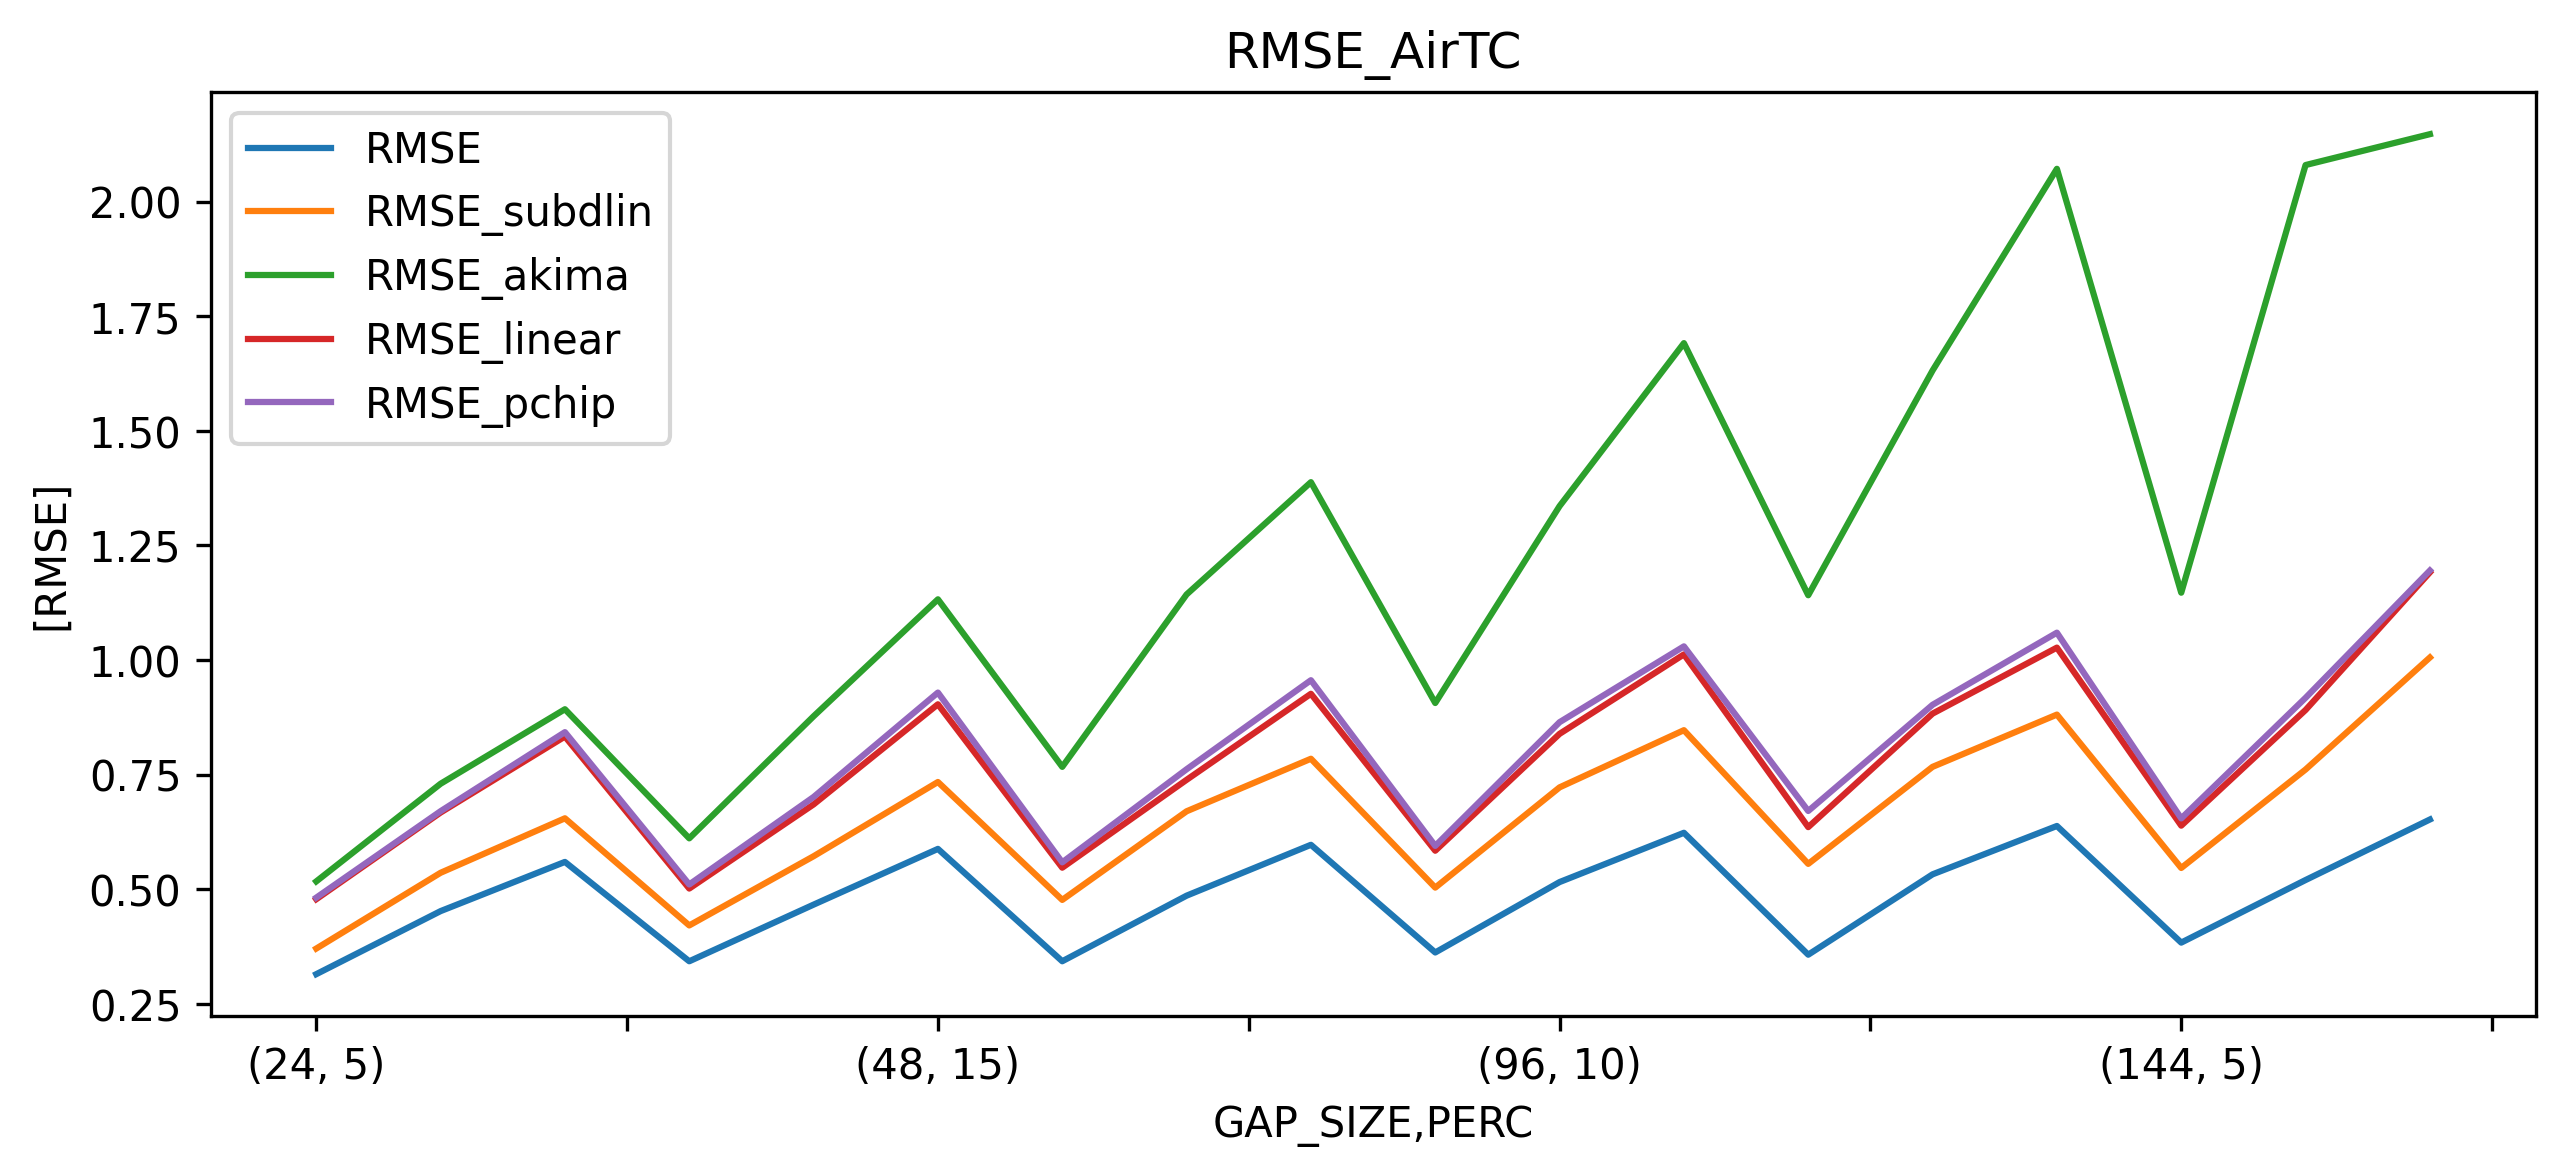

In [144]:
plt.figure(figsize=(10,4),dpi=300)
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE.plot(label="RMSE")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_sublin.plot(label="RMSE_subdlin")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_akima.plot(label="RMSE_akima")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_lin.plot(label="RMSE_linear")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_pchip.plot(label="RMSE_pchip")

plt.legend()
name="RMSE_"+varname
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig(plots_folder+name+".png")

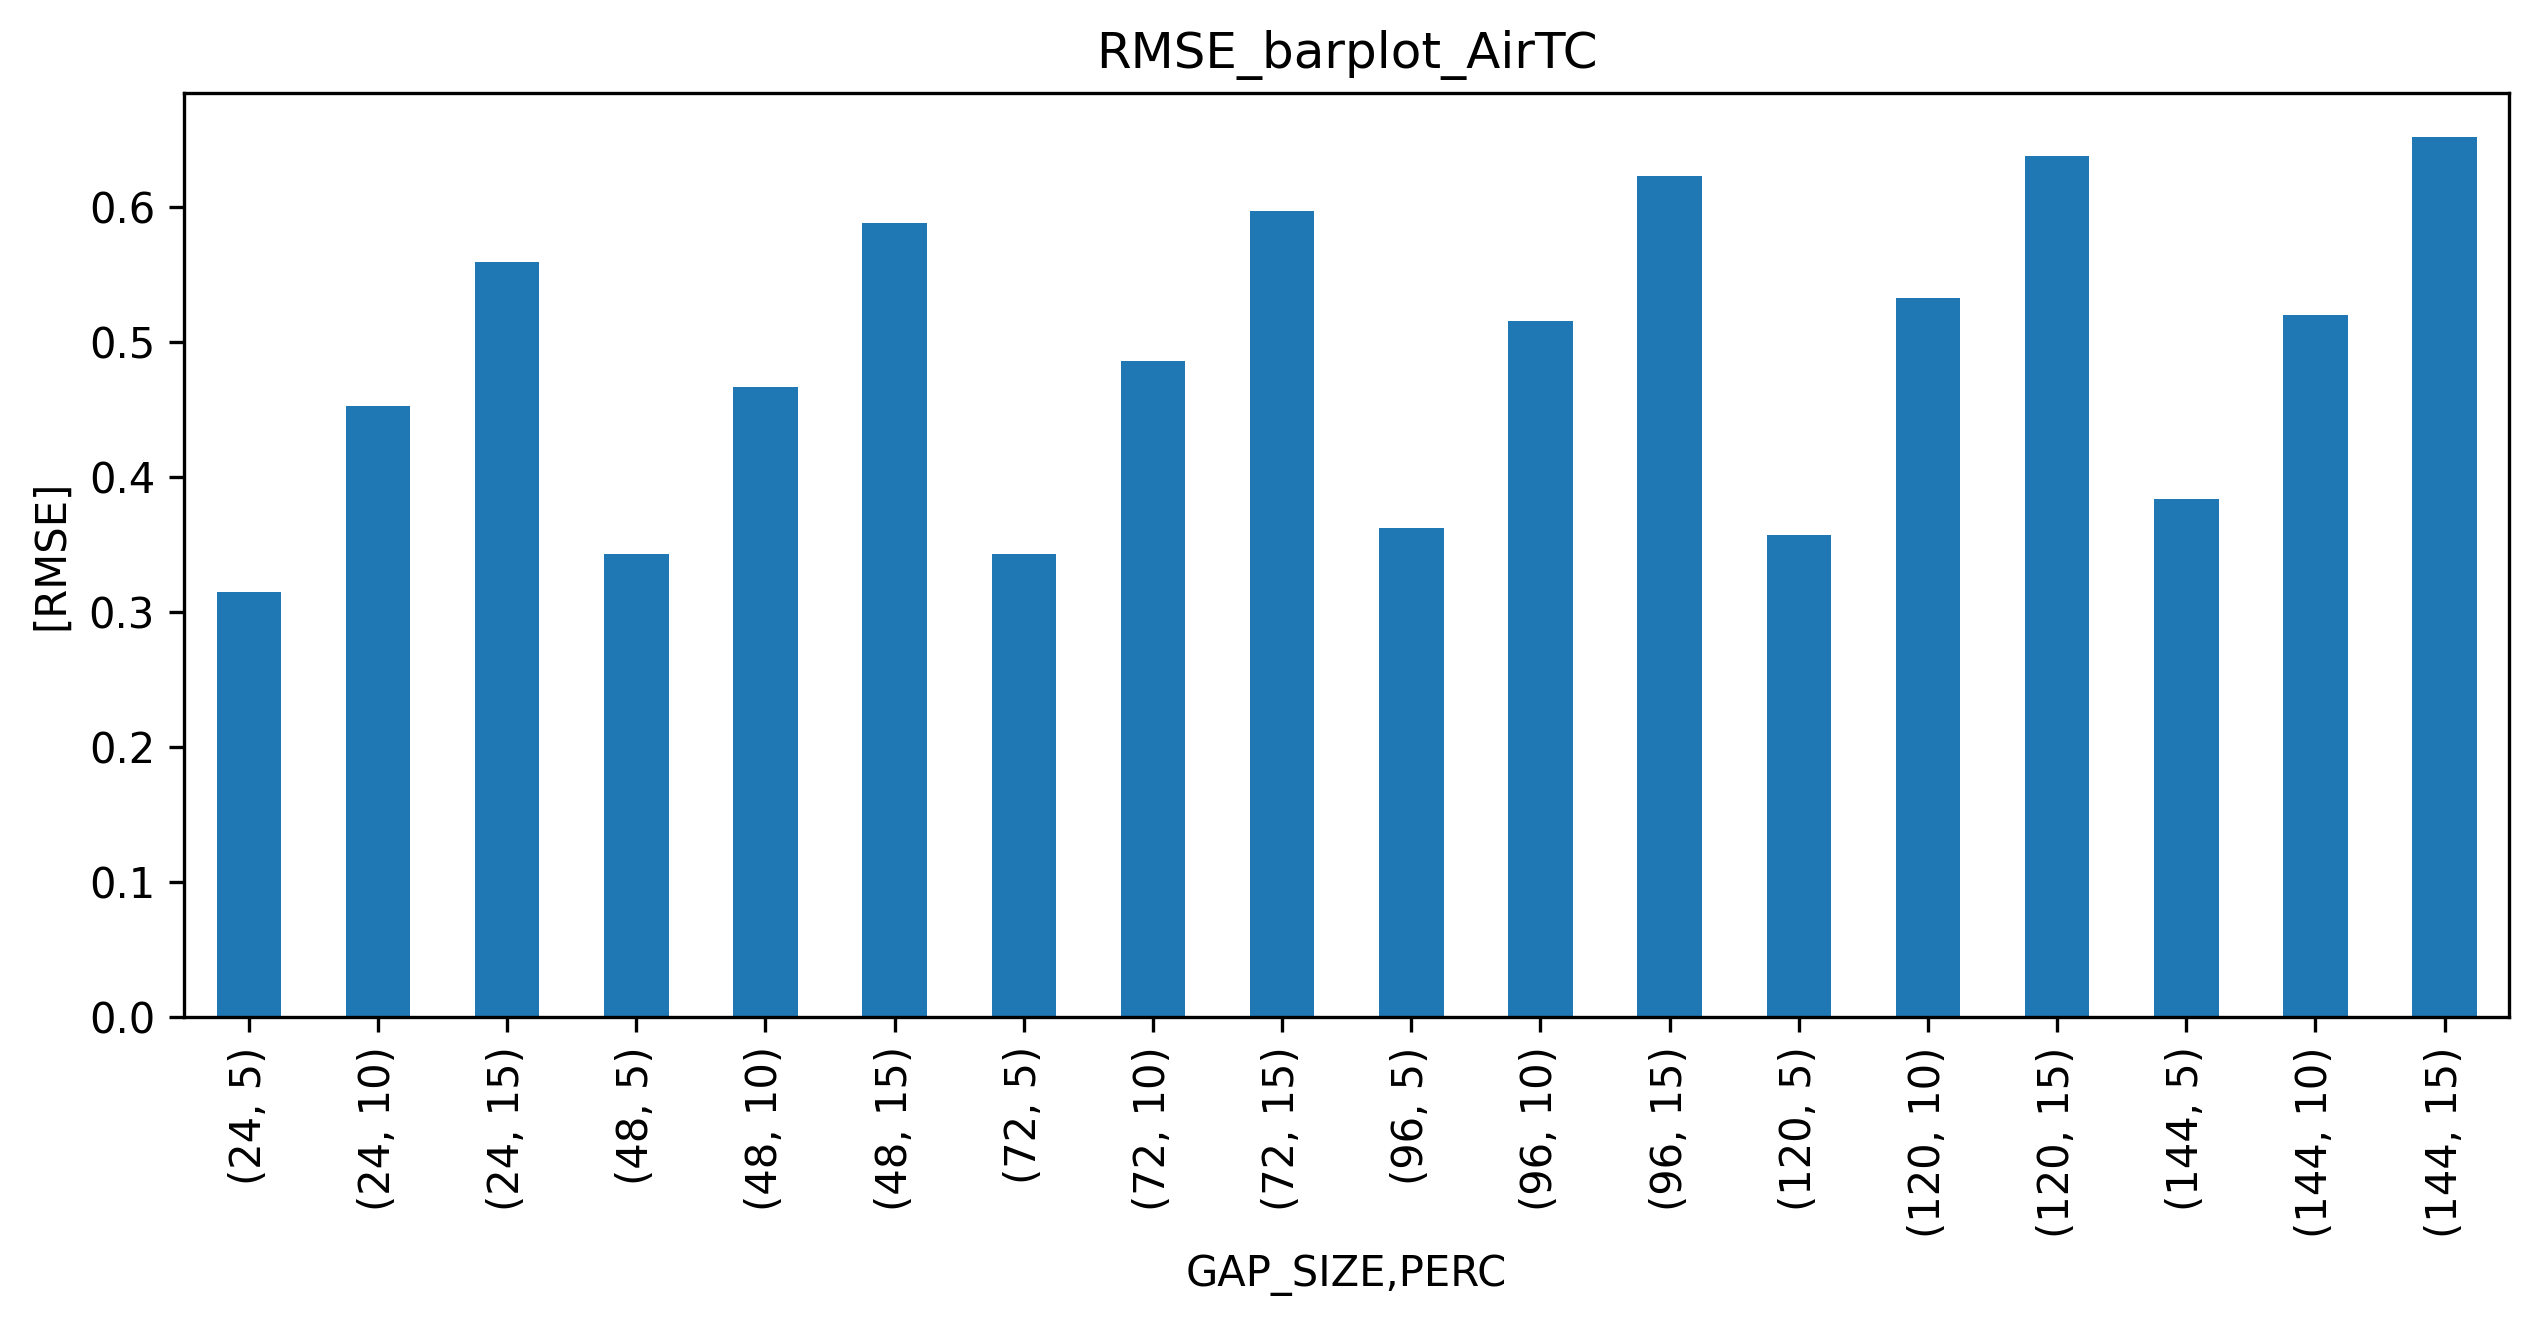

In [145]:
plt.figure(figsize=(10,4),dpi=300)

error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE.plot(kind="bar",label="RMSE")
name="RMSE_barplot_"+varname
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig(plots_folder+name+".png")

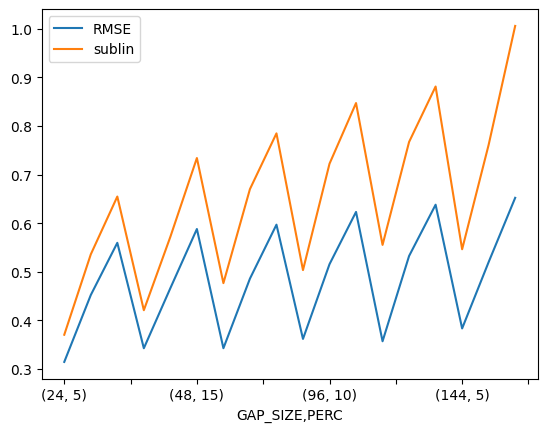

In [86]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE.plot(label="RMSE")
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean().RMSE_sublin.plot(label="sublin")
plt.legend()

In [71]:
perc=error_df["PERC"].values
gap_size=error_df["GAP_SIZE"].values
rmse=error_df["RMSE"].values

Text(0.5, 1.0, 'Covariate_Selection_RMSE_AirTC')

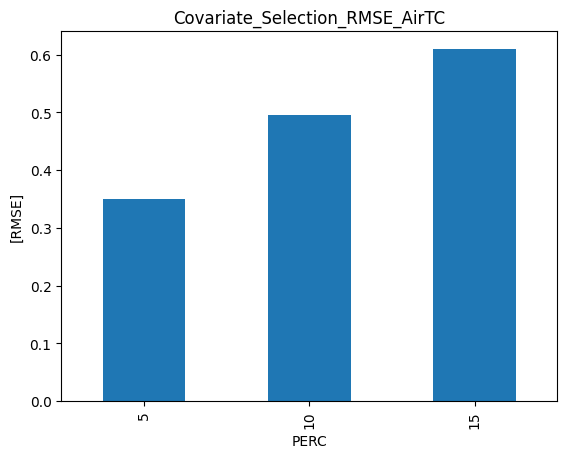

In [77]:
error_df[error_df.columns[1:]].groupby('PERC').mean().RMSE.plot(kind="bar")
name="Covariate_Selection_RMSE_"+varname
plt.ylabel("[RMSE]")
plt.title(name)
#plt.savefig(plots_folder+name+".png")

Text(0.5, 1.0, 'Covariate_Selection_RMSE_AirTC')

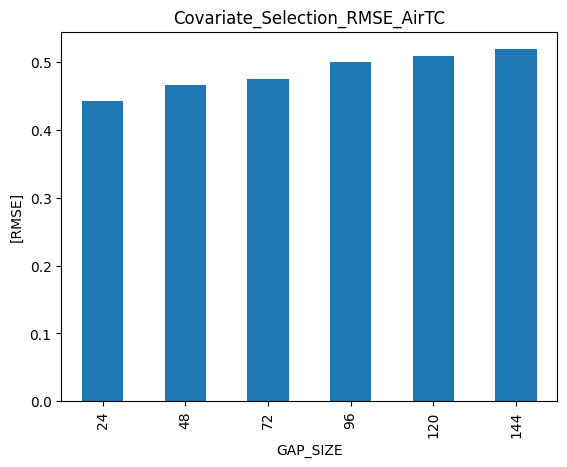

In [79]:
error_df[error_df.columns[1:]].groupby('GAP_SIZE').mean().RMSE.plot(kind="bar")
name="Covariate_Selection_RMSE_"+varname
plt.ylabel("[RMSE]")
plt.title(name)
#plt.savefig(plots_folder+name+".png")

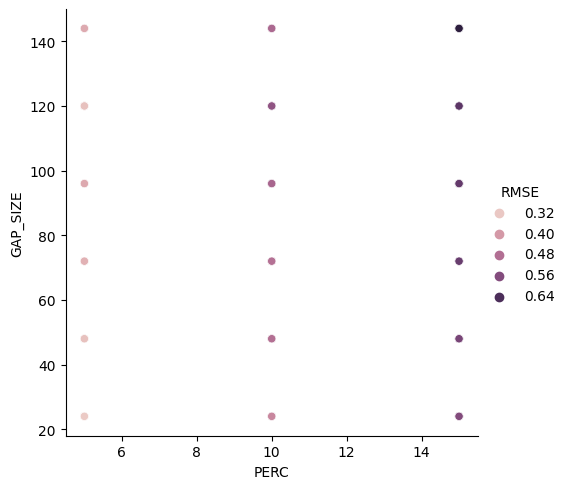

In [72]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

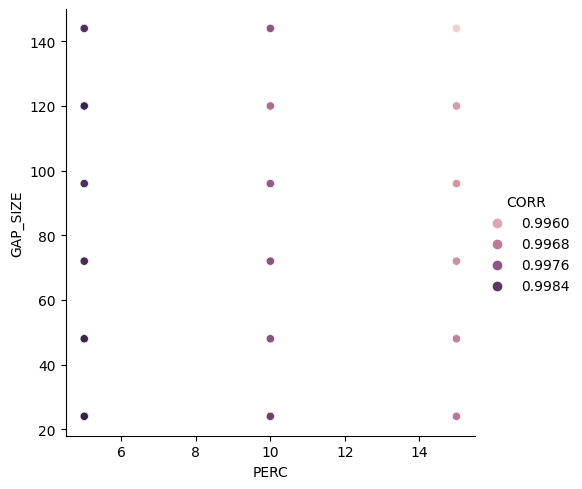

In [73]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

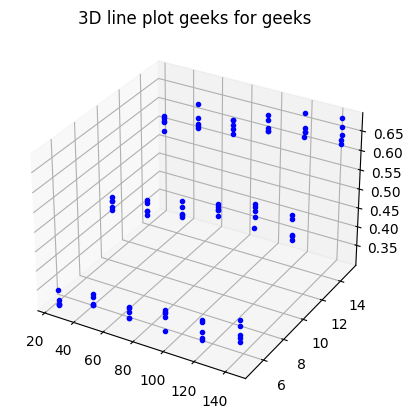

In [74]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [187]:
N = 50

In [188]:
#gap-filling with one covariate
covar2 = ms_pully["t2m"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

job Id is: 2921174027
progress 100.000%       
        job Id is: 9242885
progress 100.000%       
        job Id is: 1377670031
progress 100.000%       
        job Id is: 2757990067
progress 100.000%       
        job Id is: 4153518104
progress 100.000%       
        job Id is: 1213671142
progress 100.000%       
        job Id is: 2575721376
progress 100.000%       
        job Id is: 3966406413
progress 100.000%       
        job Id is: 1043586531
progress 100.000%       
        job Id is: 2427167026
progress 100.000%       
        job Id is: 3794017120
progress 100.000%       
        job Id is: 861323918
progress 100.000%       
        job Id is: 2222927012
progress 100.000%       
        job Id is: 3580624005
progress 100.000%       
        job Id is: 654599033
progress 100.000%       
        job Id is: 2013333970
progress 100.000%       
        job Id is: 3391263609
progress 100.000%       
        job Id is: 458310851
progress 100.000%       
        job Id is: 18289

In [189]:
#gap-filling with one covariate
covar2 = ms_pully["t2m"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L3_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

job Id is: 4270530809
progress 100.000%      
        job Id is: 726818649
progress 100.000%      
        job Id is: 1481088084
progress 100.000%      
        job Id is: 2235033120
progress 100.000%      
        job Id is: 2987220755
progress 100.000%      
        job Id is: 3737341491
progress 100.000%      
        job Id is: 197118963
progress 100.000%      
        job Id is: 952671418
progress 100.000%      
        job Id is: 1708660374
progress 100.000%      
        job Id is: 2480374130
progress 100.000%      
        job Id is: 3235874685
progress 100.000%      
        job Id is: 4026299243
progress 100.000%      
        job Id is: 487975903
progress 100.000%      
        job Id is: 1239794658
progress 100.000%      
        job Id is: 1991322913
progress 100.000%      
        job Id is: 2751629968
progress 100.000%      
        job Id is: 3512235224
progress 100.000%      
        job Id is: 4268589488
progress 100.000%      
        job Id is: 734193060
progress 10

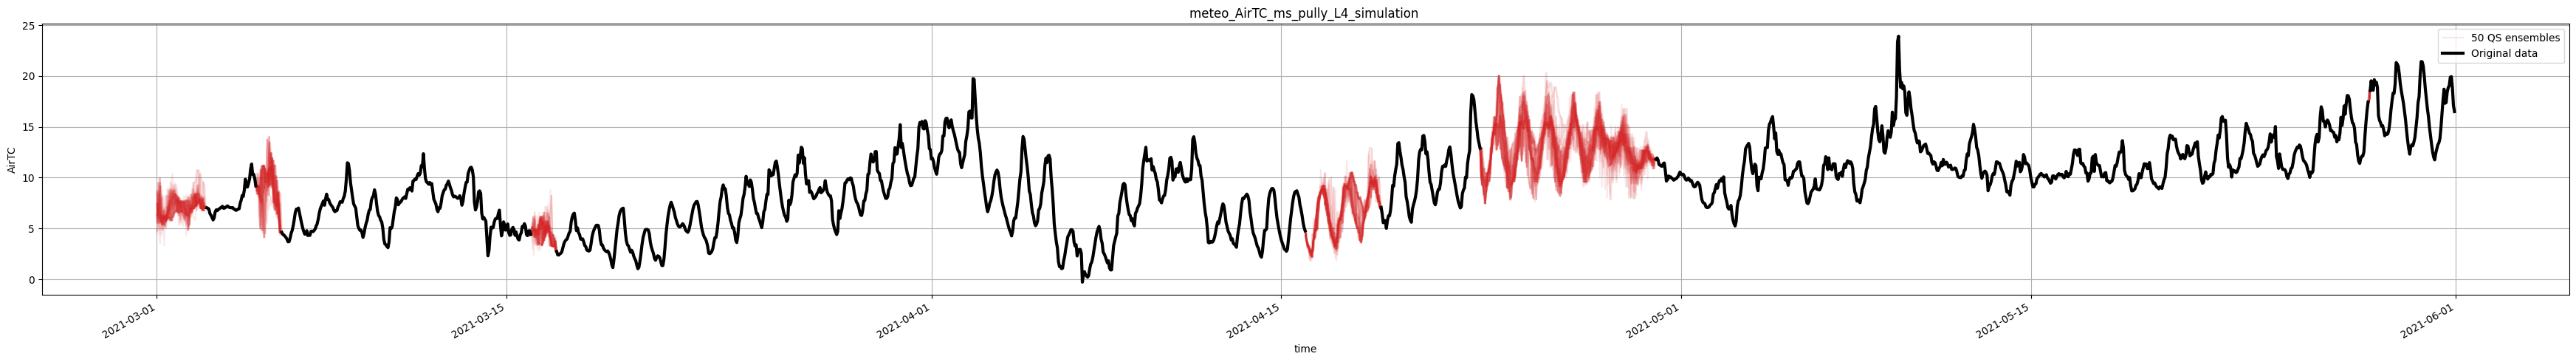

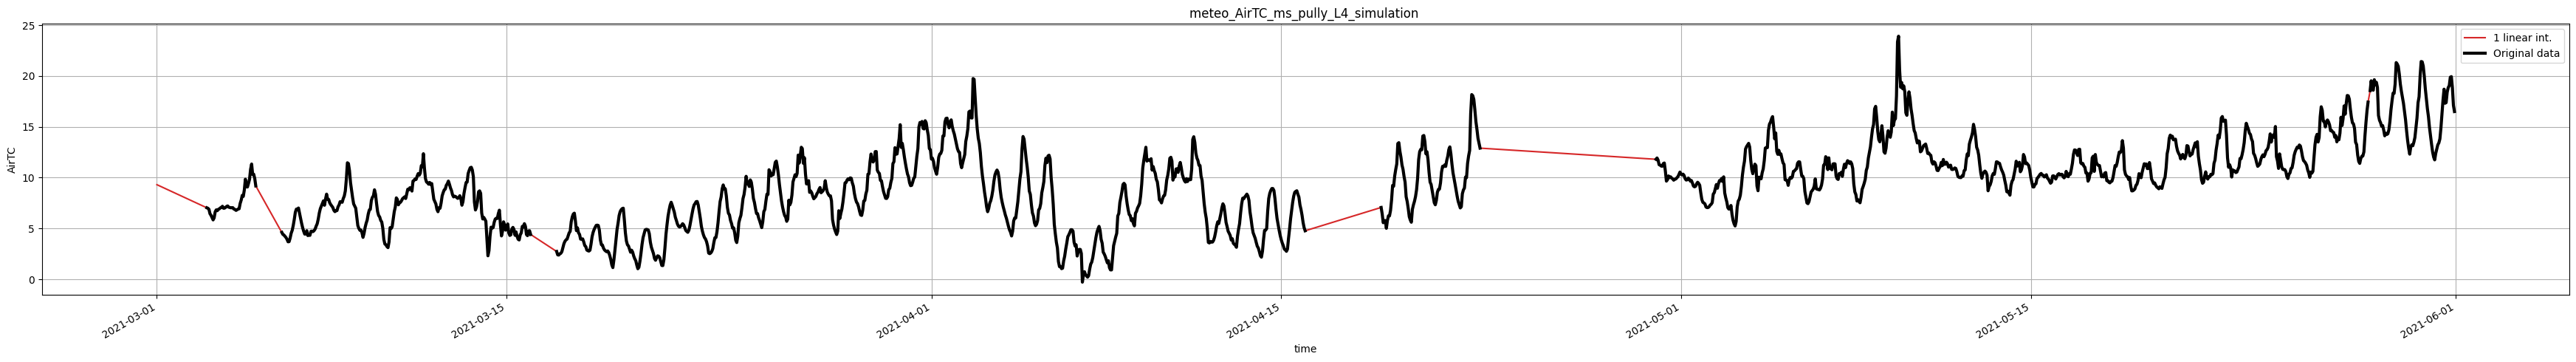

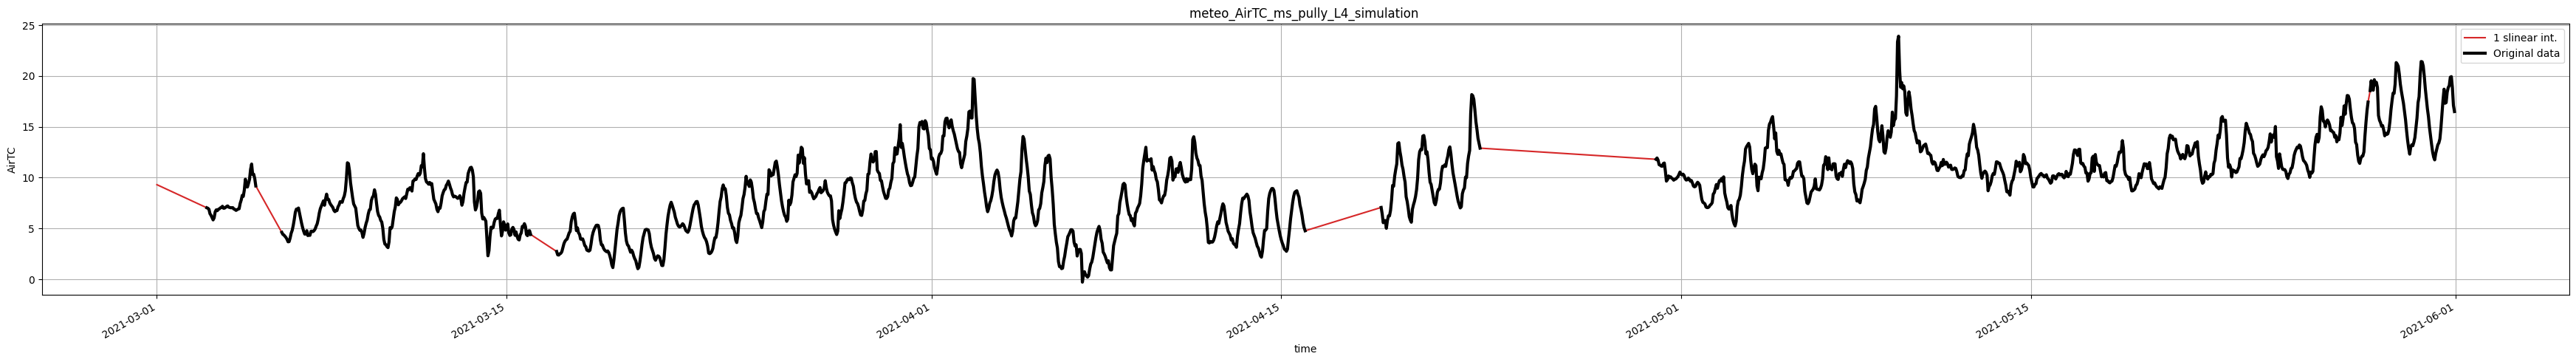

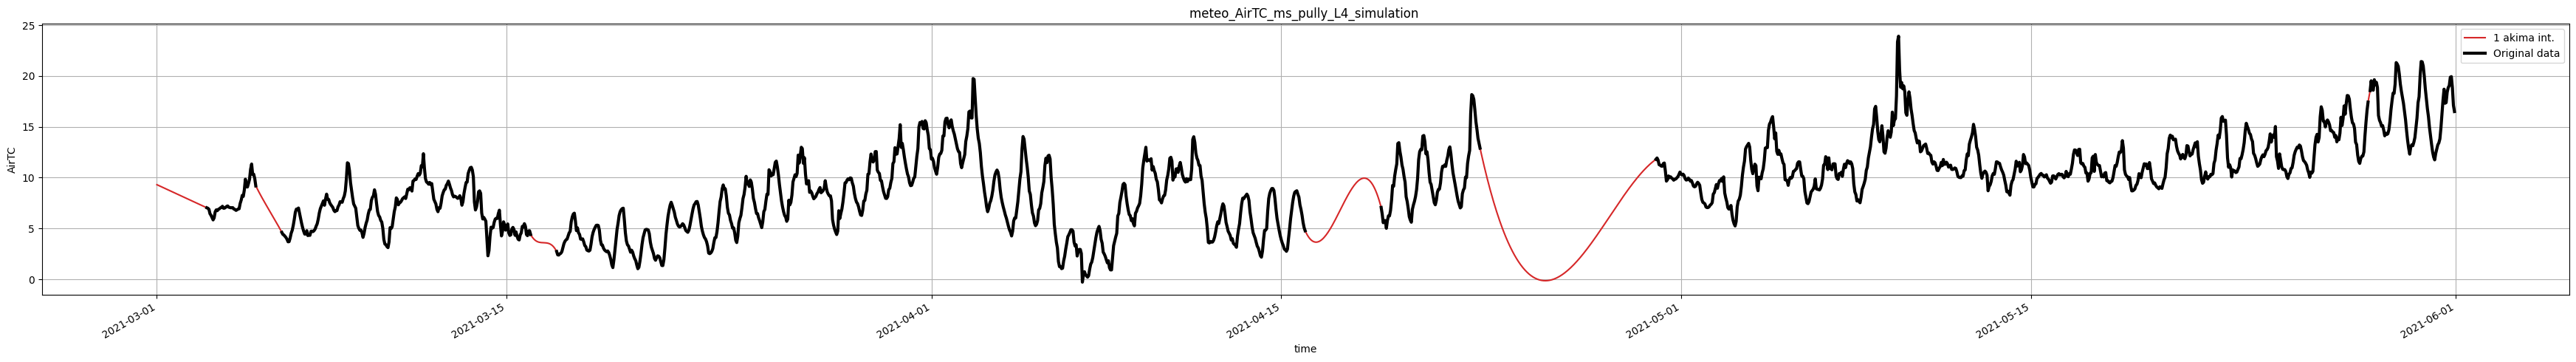

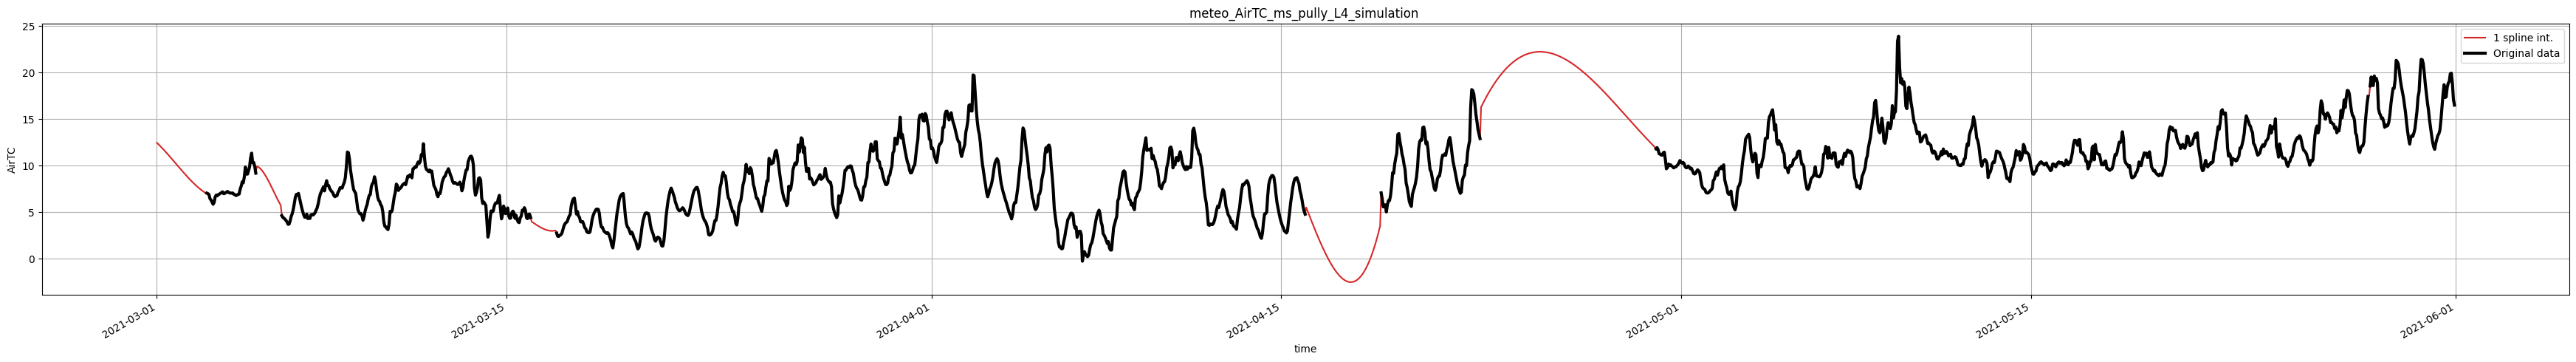

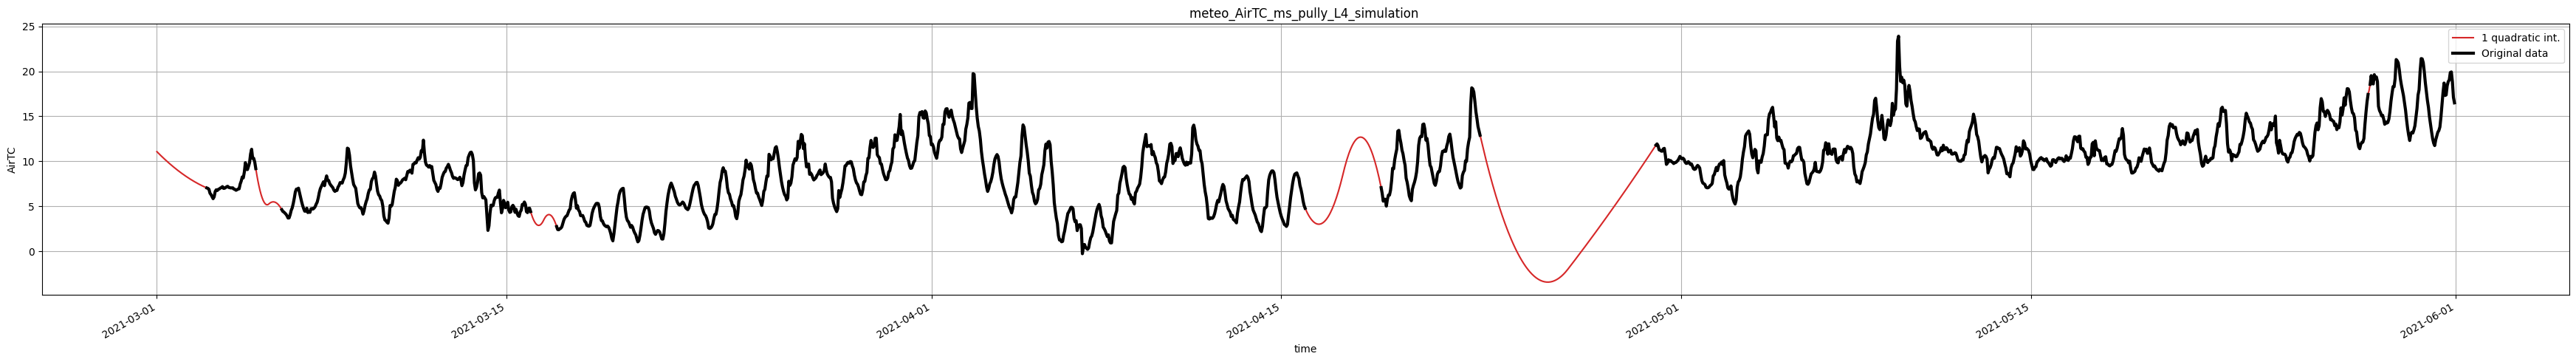

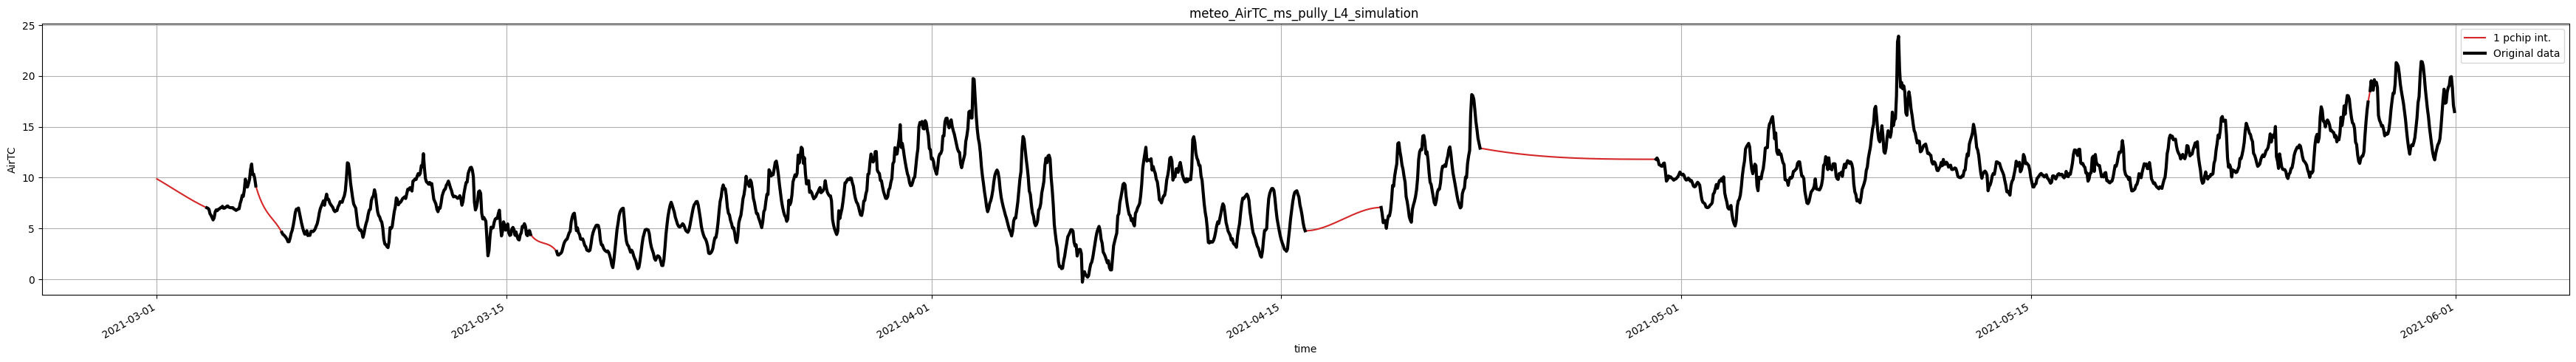

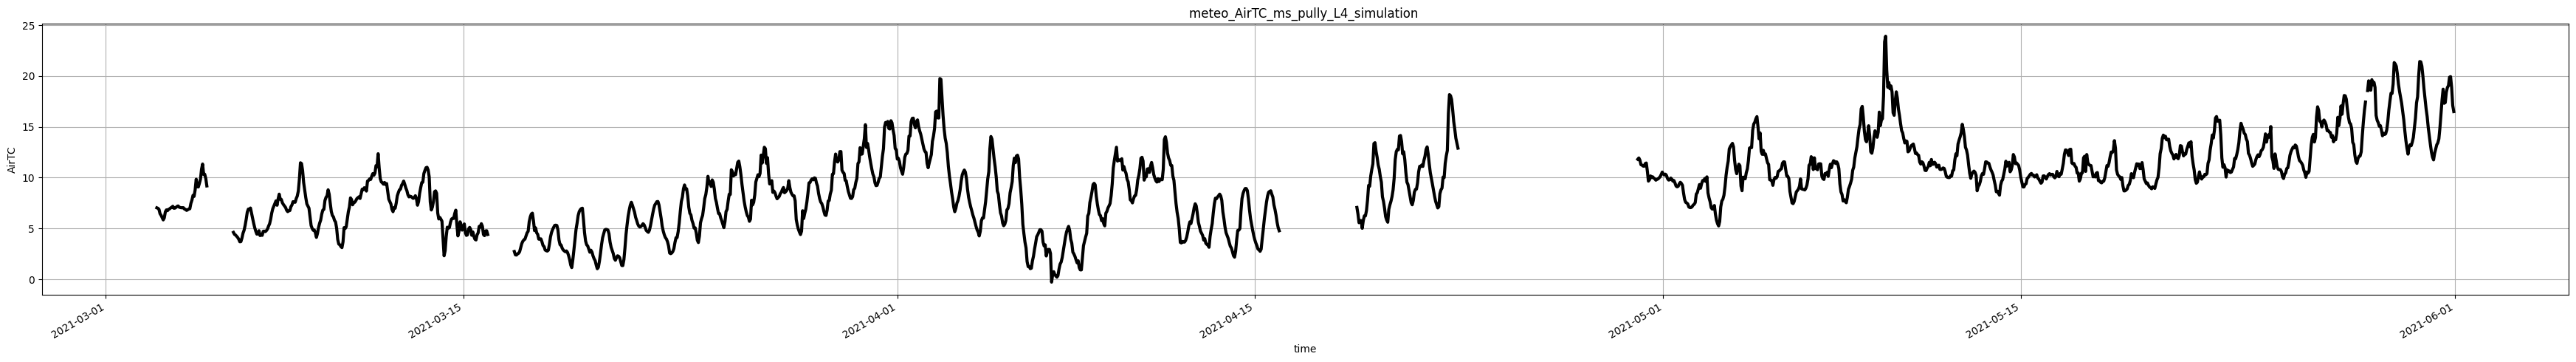

In [190]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=plots_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

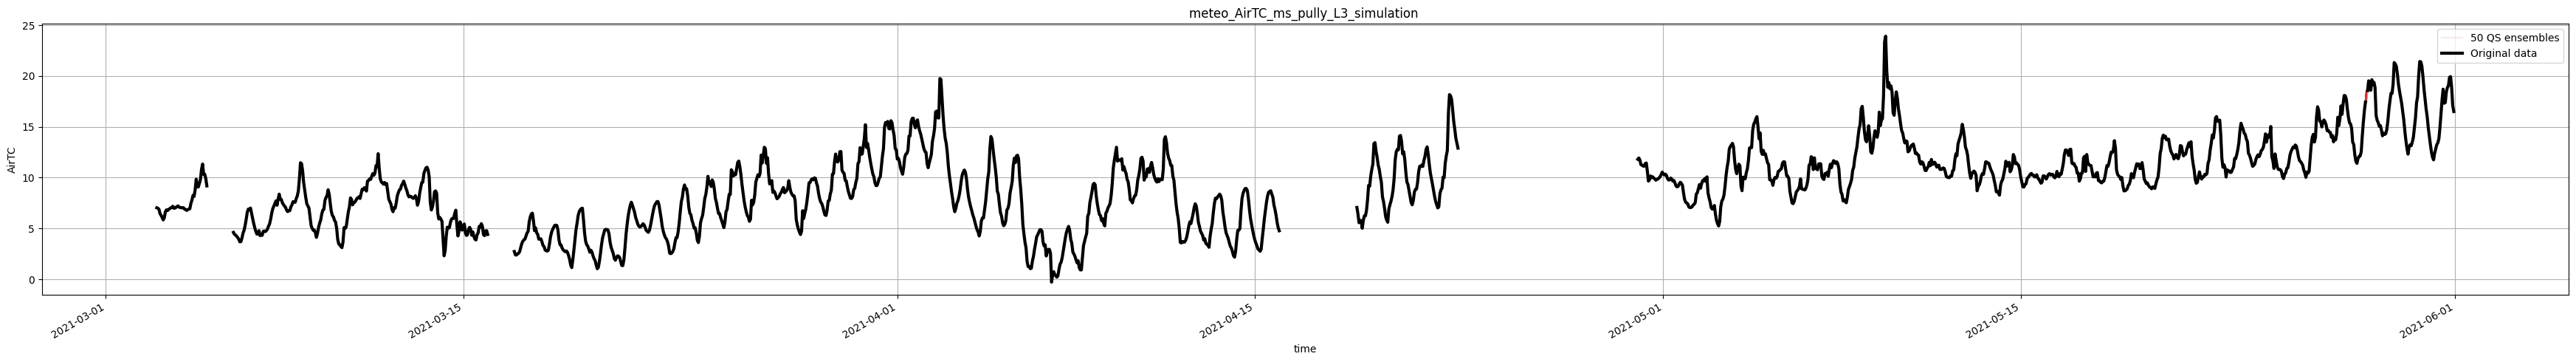

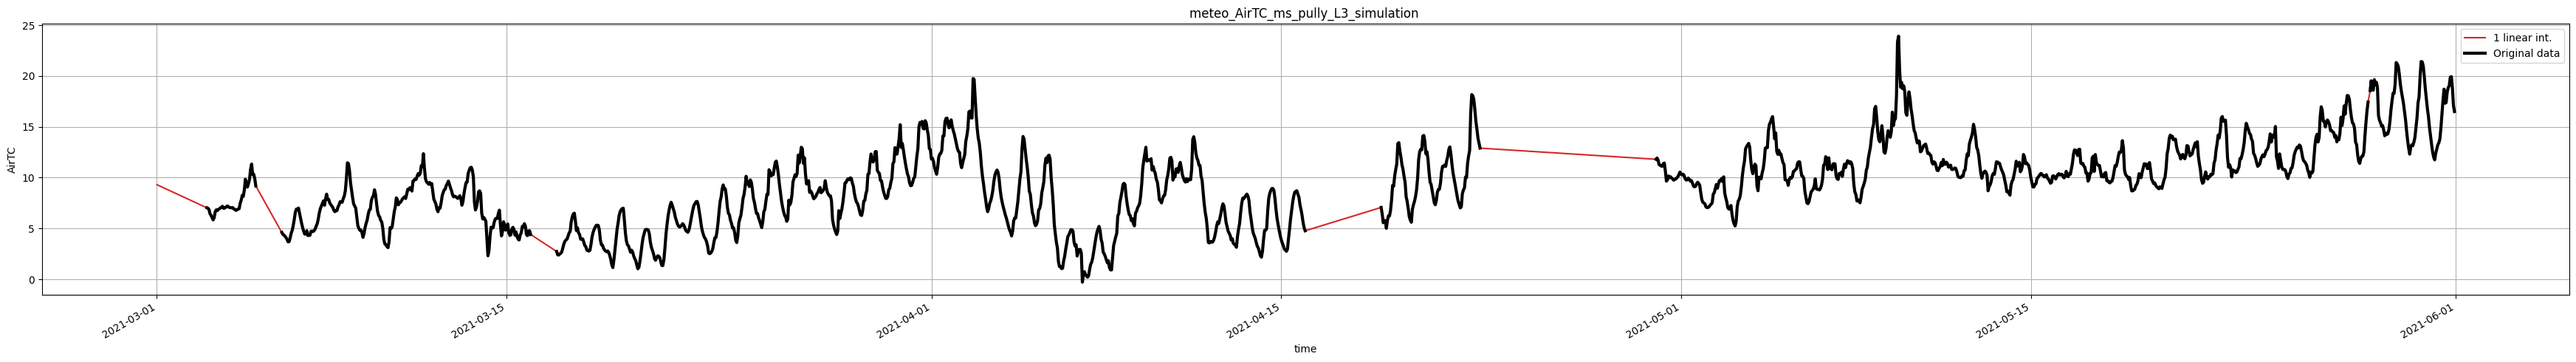

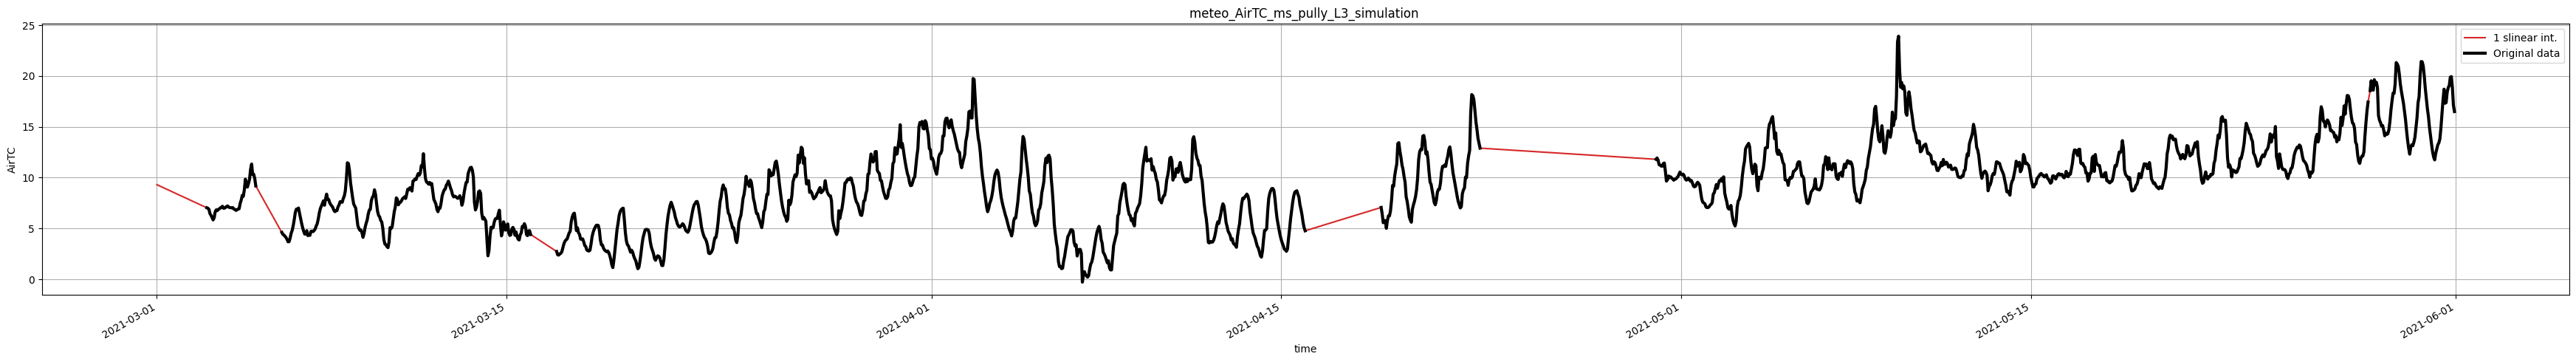

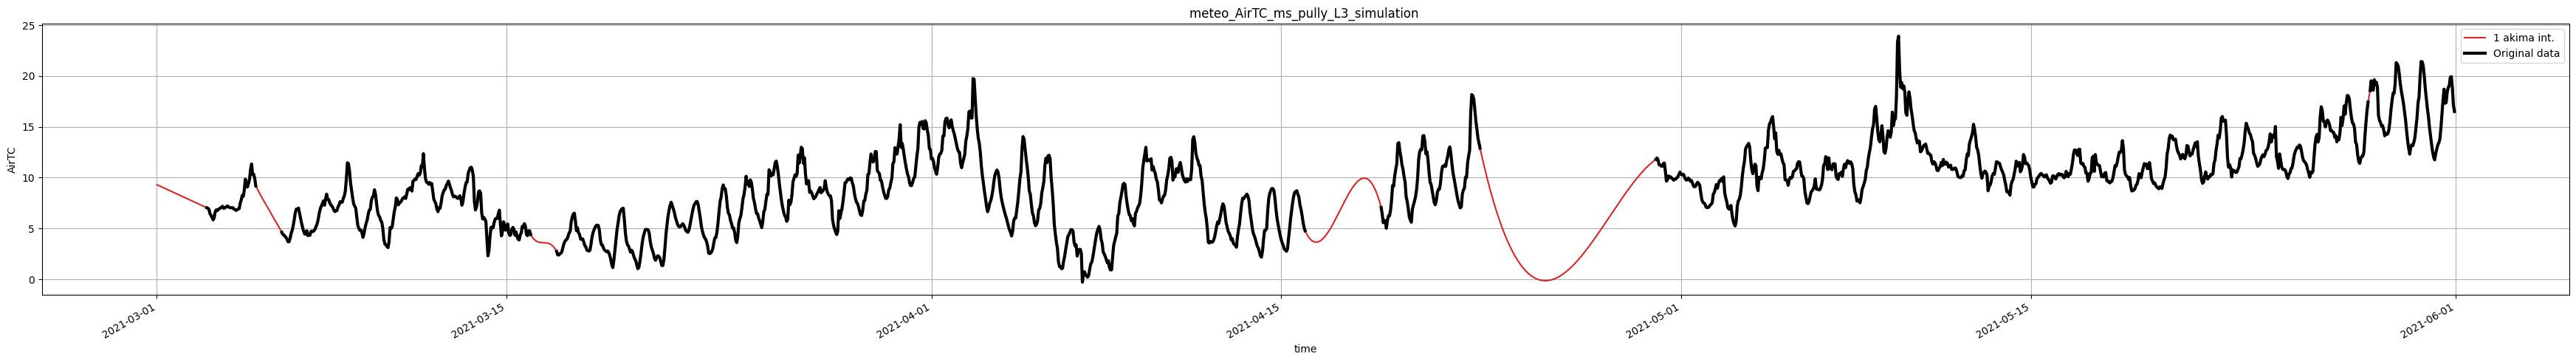

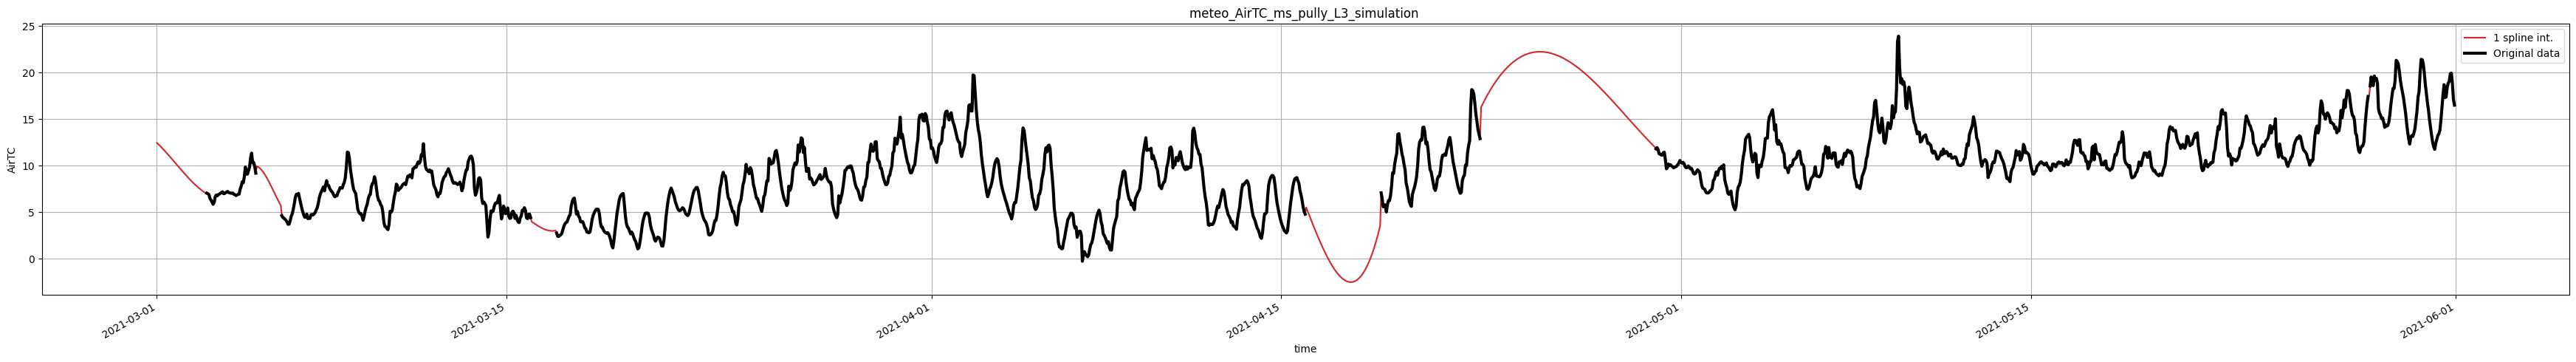

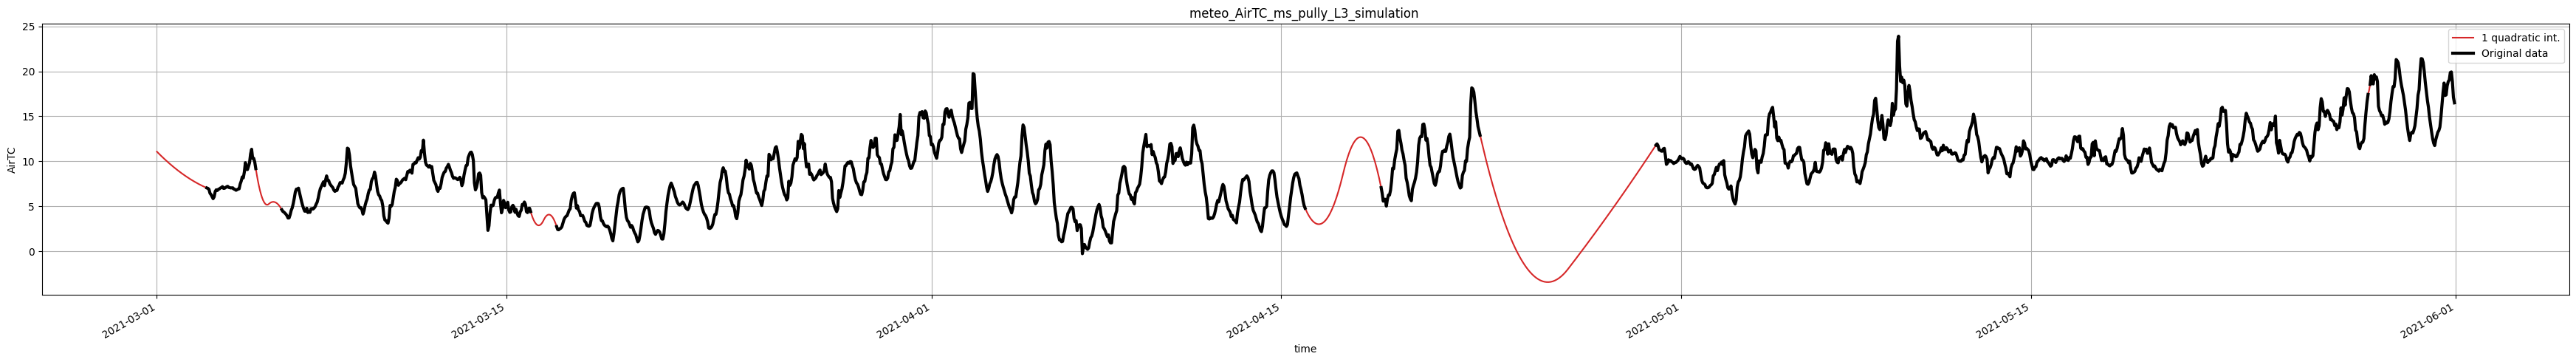

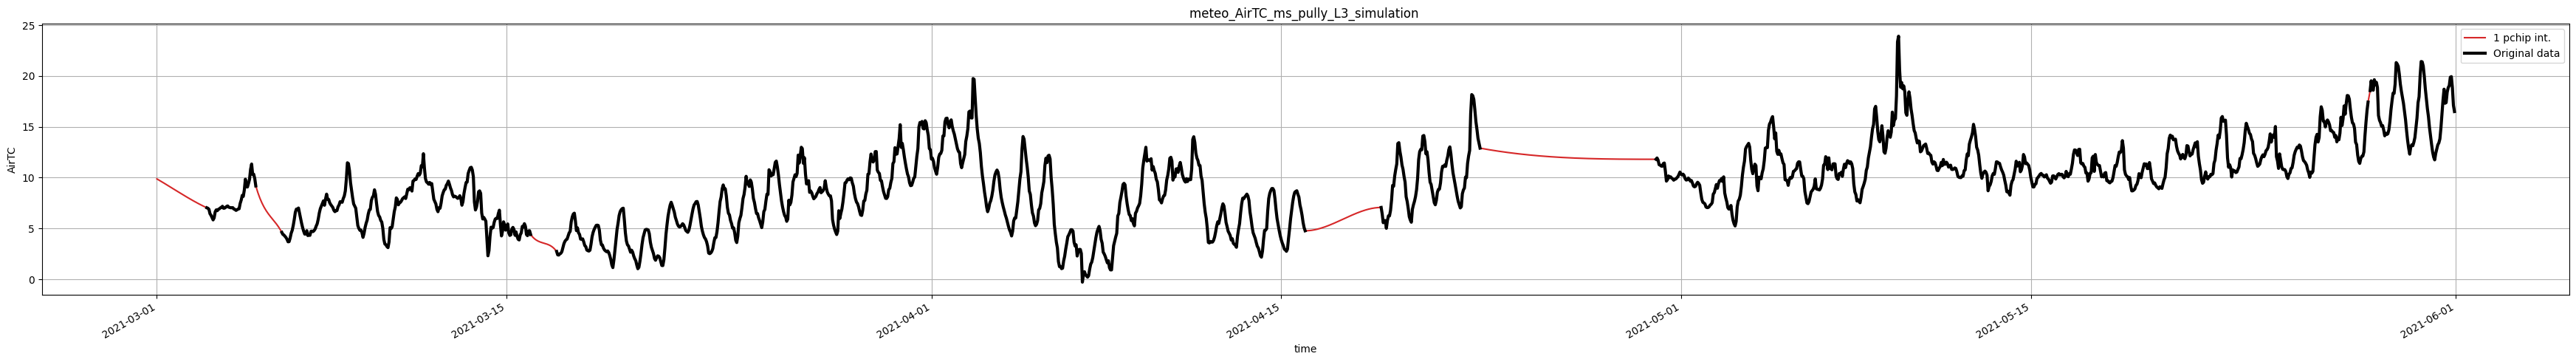

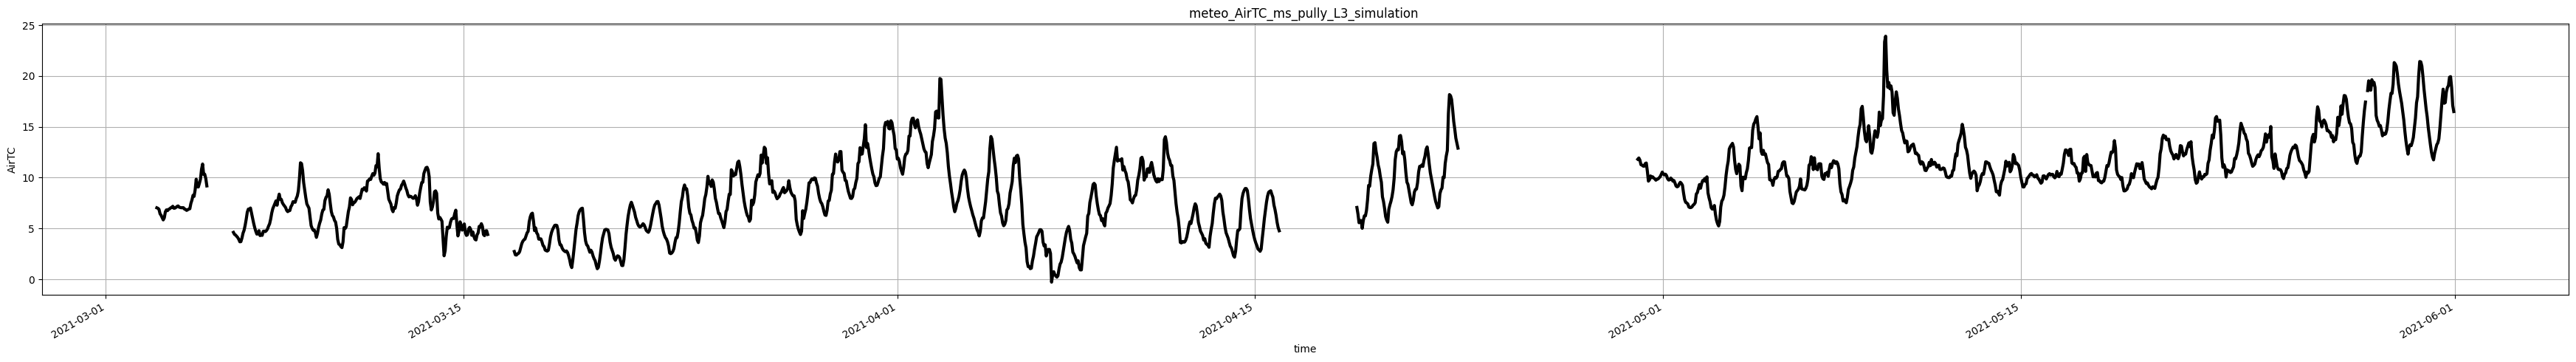

In [191]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=plots_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [192]:
save_name="meteo_L3_"+varname+"_ms_pully_50member.nc"

L3_simulation.to_netcdf(recs_folder+save_name)

xr.open_dataset(recs_folder+save_name)

<xarray.Dataset>
Dimensions:       (realizations: 50, time: 26280)
Coordinates:
  * realizations  (realizations) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
  * time          (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    AirTC         (realizations, time) float32 ...

In [193]:
save_name="meteo_L4_"+varname+"_ms_pully_50member.nc"

L4_simulation.to_netcdf(recs_folder+save_name)

xr.open_dataset(recs_folder+save_name)

<xarray.Dataset>
Dimensions:       (realizations: 50, time: 26280)
Coordinates:
  * realizations  (realizations) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
  * time          (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    AirTC         (realizations, time) float32 ...

## Fill Air Pressure Data

### understand the average gap size in data

In [194]:
varname="BP"


meteo_orig_bp has 955 nans in 26280 data points
meteo_orig_bp has 3.63% missing values
meteo_orig_bp has 88 gaps with 1.0 median gap size
meteo_orig_bp has 88 gaps with 10.85 mean gap size


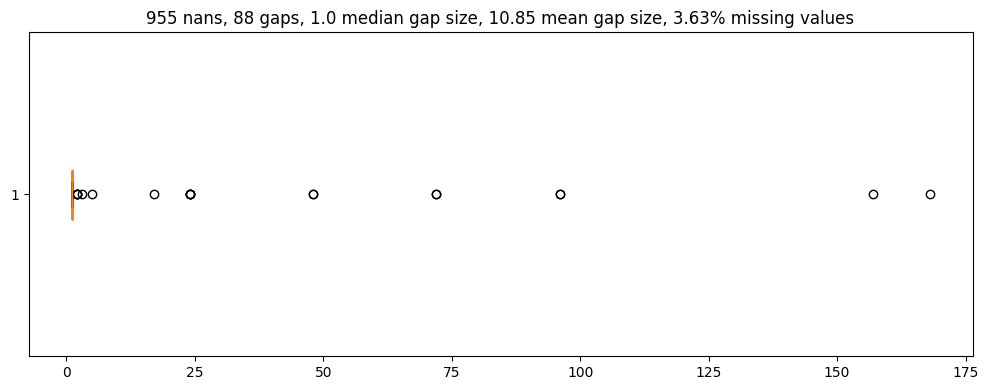

In [195]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_bp",plot_folder=output_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
print(datetime.datetime.now())

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="sp",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2="sp",cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2="sp",cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="PS",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
error_df

In [103]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")


In [ ]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

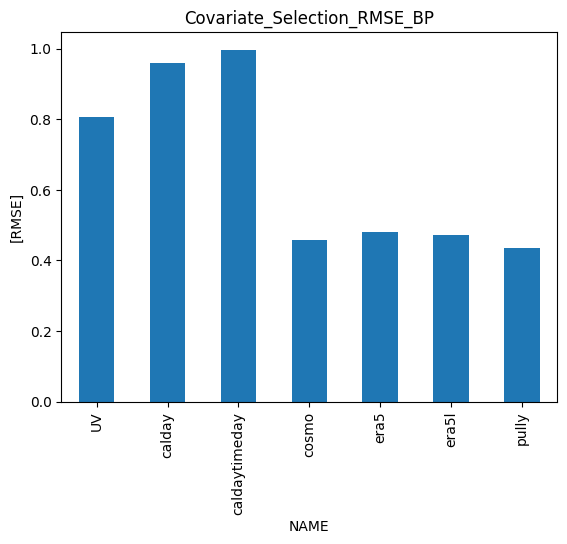

In [104]:
error_df.groupby('NAME').mean().RMSE.plot(kind="bar")
name="Covariate_Selection_RMSE_"+varname
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig(plots_folder+name+".png")

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="sp",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="sp",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="sp",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
perc=error_df["PERC"].values
gap_size=error_df["GAP_SIZE"].values
rmse=error_df["RMSE"].values

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [196]:
N = 50

In [197]:
#gap-filling with one covariate
covar2 = ms_pully["sp"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

job Id is: 1960677010
progress 100.000%       
        job Id is: 3943268203
progress 100.000%       
        job Id is: 1648786802
progress 100.000%       
        job Id is: 3028680336
progress 100.000%       
        job Id is: 111341267
progress 100.000%       
        job Id is: 1503396993
progress 100.000%       
        job Id is: 2900617420
progress 100.000%       
        job Id is: 3525751
progress 100.000%       
        job Id is: 1417169279
progress 100.000%       
        job Id is: 3396739658
progress 100.000%       
        job Id is: 467312285
progress 100.000%       
        job Id is: 2439872962
progress 100.000%       
        job Id is: 772874003
progress 100.000%       
        job Id is: 3386470606
progress 100.000%       
        job Id is: 1707640773
progress 100.000%       
        job Id is: 3083254358
progress 100.000%       
        job Id is: 163750248
progress 100.000%       
        job Id is: 2159116382
progress 100.000%       
        job Id is: 414027

In [198]:
#gap-filling with one covariate
covar2 = ms_pully["sp"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L3_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

job Id is: 3078745547
progress 100.000%      
        job Id is: 3821920018
progress 100.000%      
        job Id is: 275205095
progress 100.000%      
        job Id is: 1021893567
progress 100.000%      
        job Id is: 1772407939
progress 100.000%      
        job Id is: 2524456710
progress 100.000%      
        job Id is: 3266662980
progress 100.000%      
        job Id is: 4012656350
progress 100.000%      
        job Id is: 465009624
progress 100.000%      
        job Id is: 1233494896
progress 100.000%      
        job Id is: 1984718266
progress 100.000%      
        job Id is: 2758082639
progress 100.000%      
        job Id is: 3532804911
progress 100.000%      
        job Id is: 3228287
progress 100.000%      
        job Id is: 748856657
progress 100.000%      
        job Id is: 1497189827
progress 100.000%      
        job Id is: 2252326098
progress 100.000%      
        job Id is: 3001379867
progress 100.000%      
        job Id is: 3756047038
progress 100

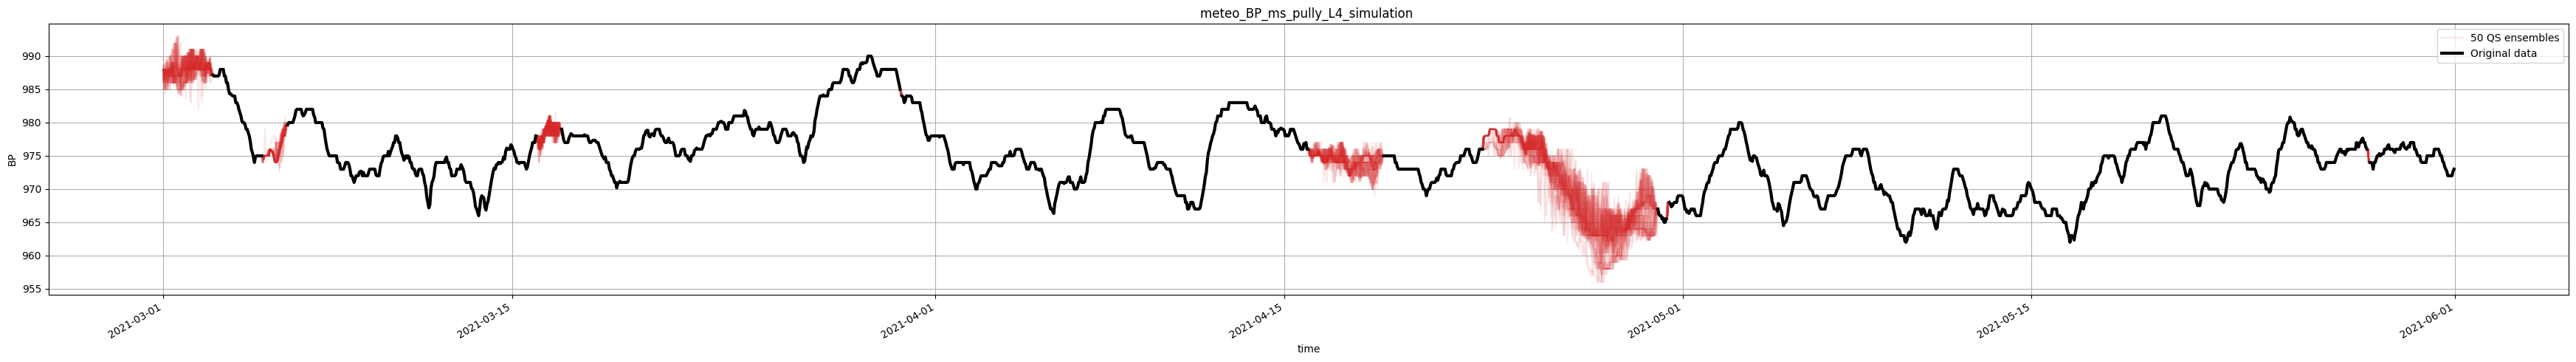

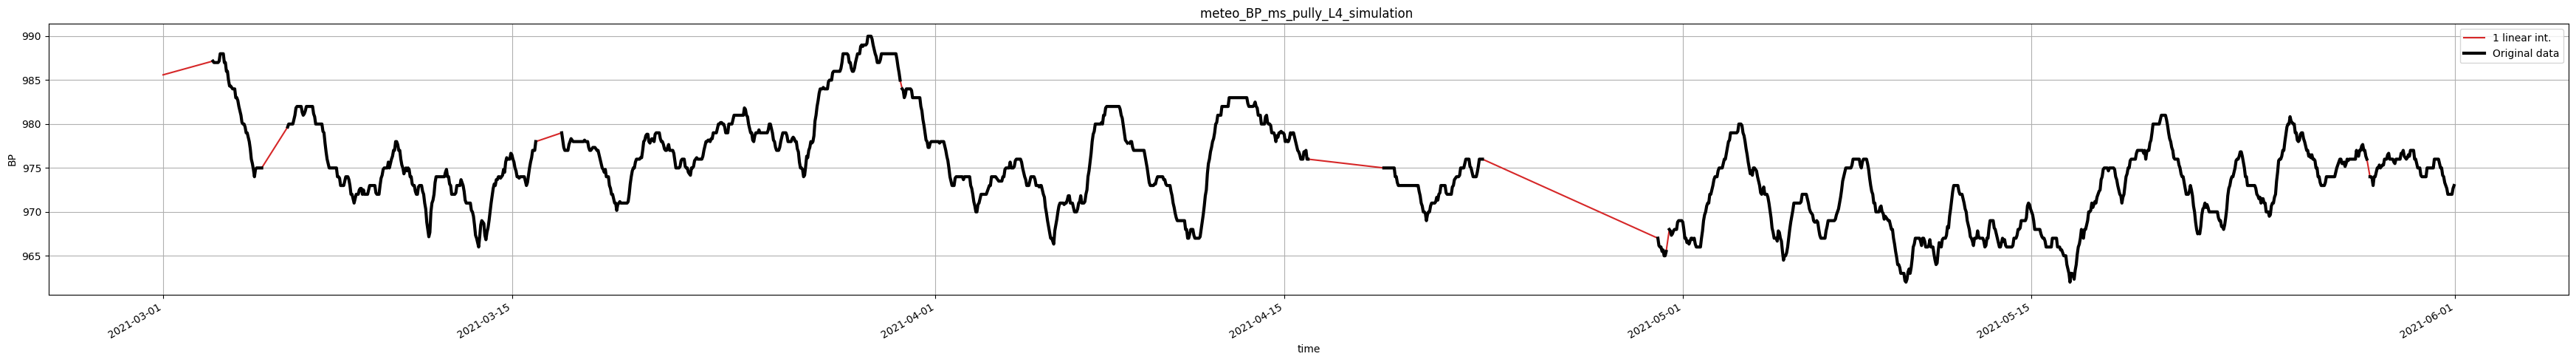

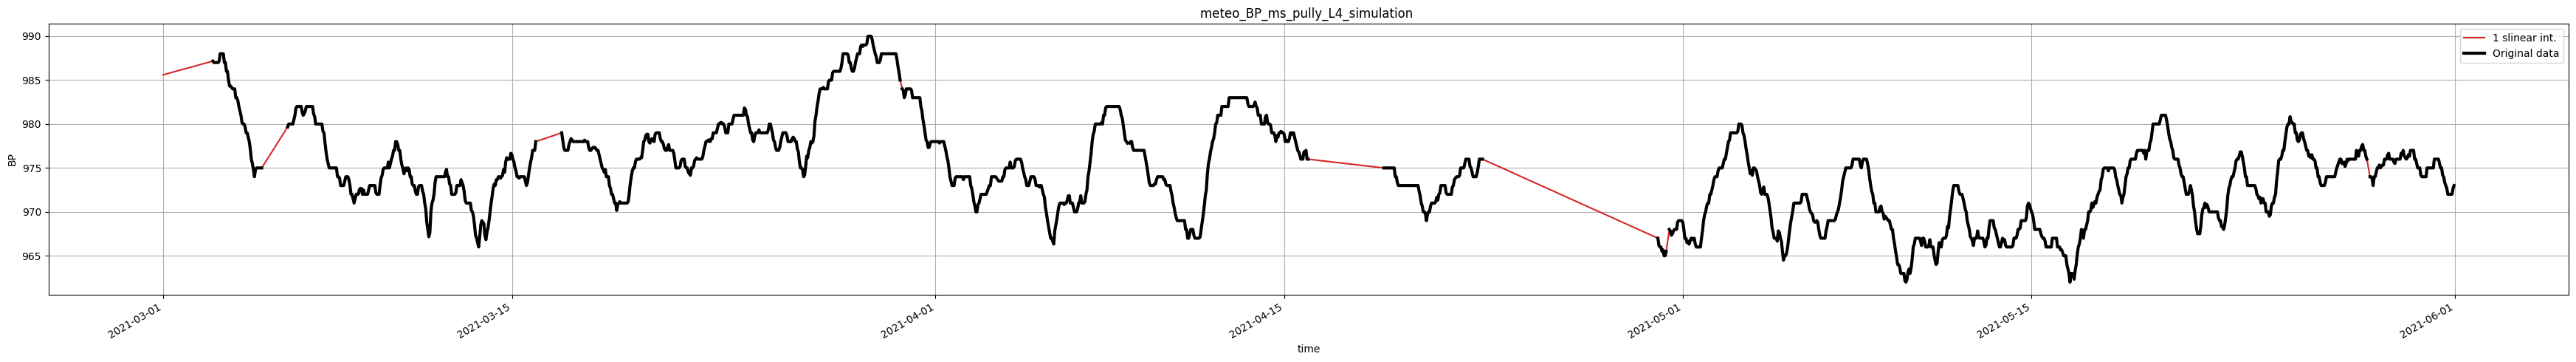

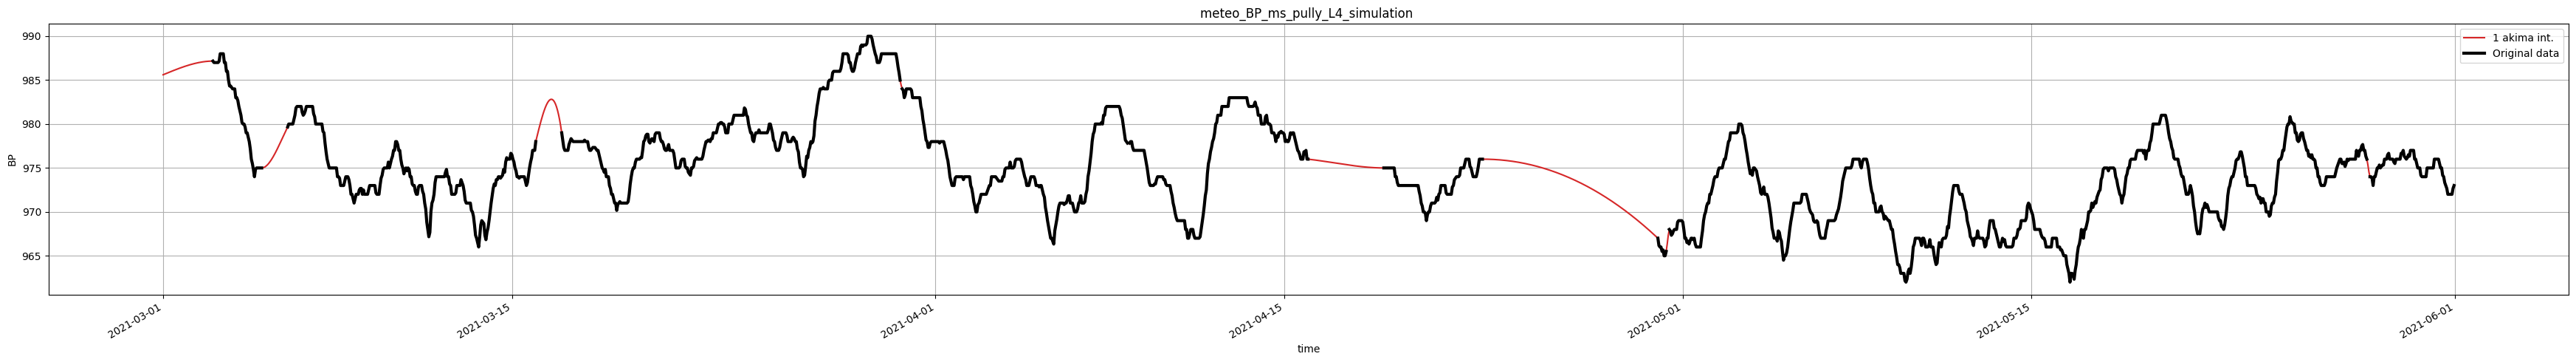

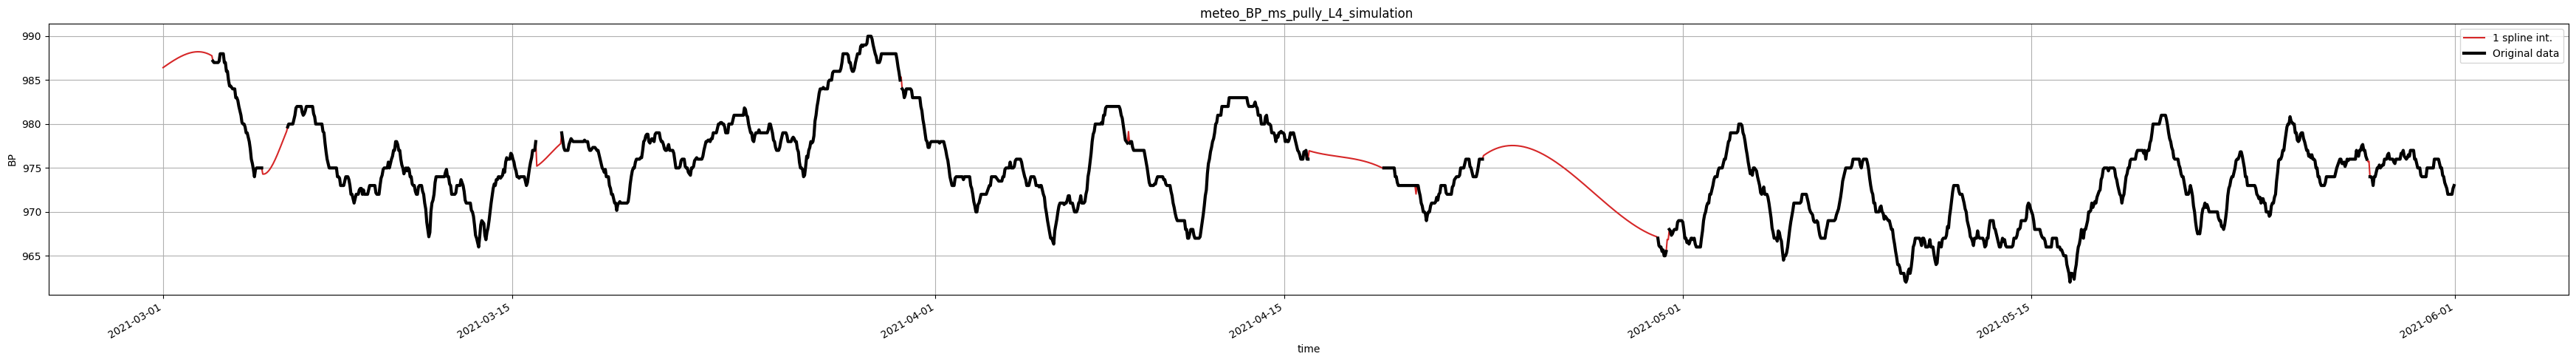

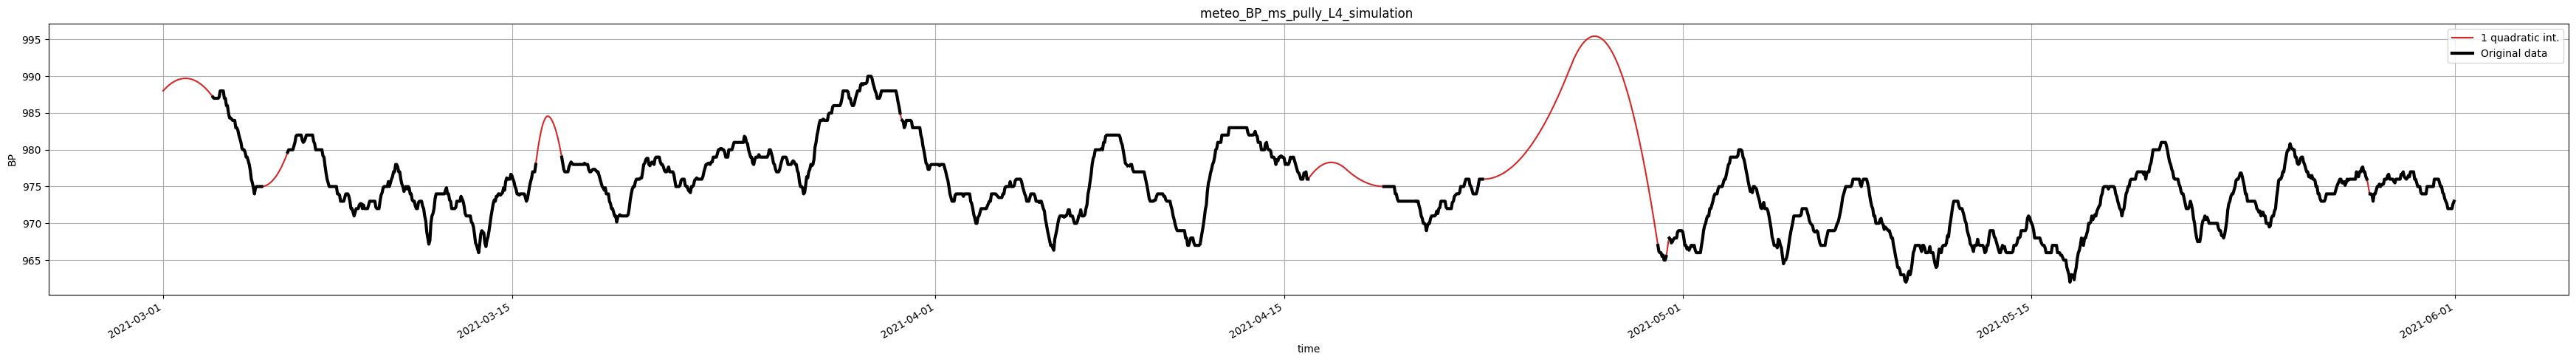

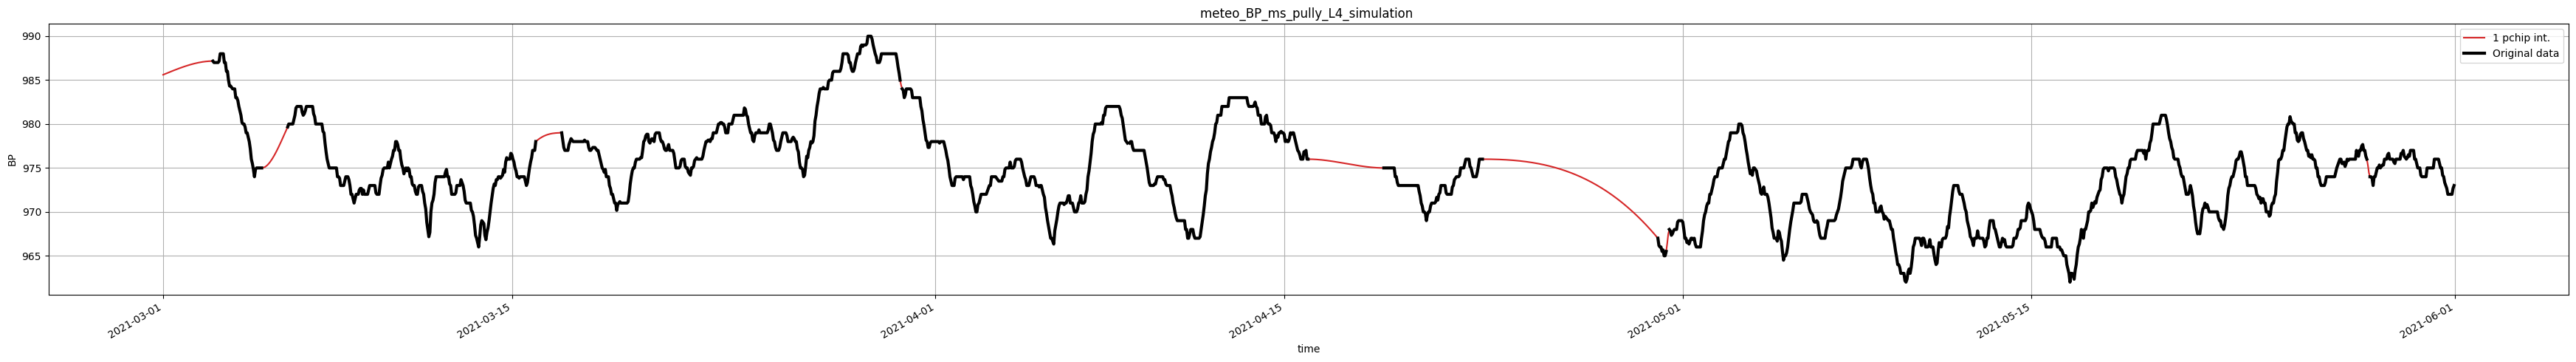

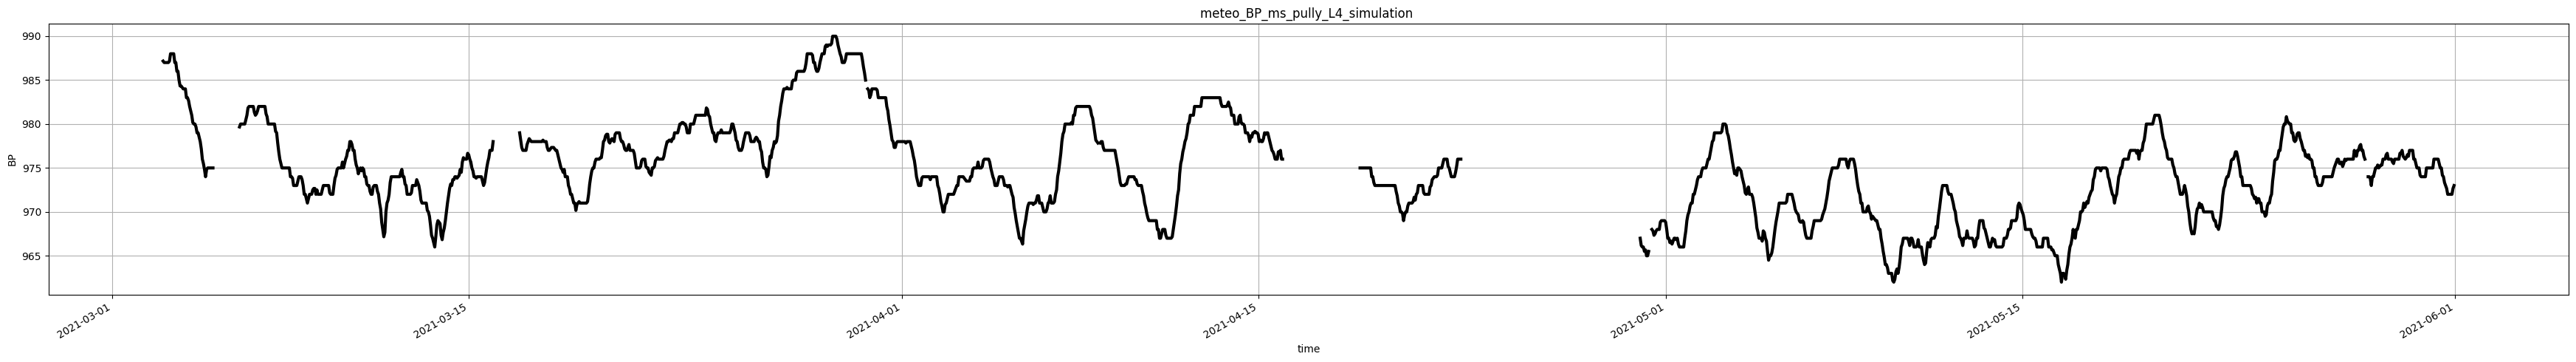

In [199]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

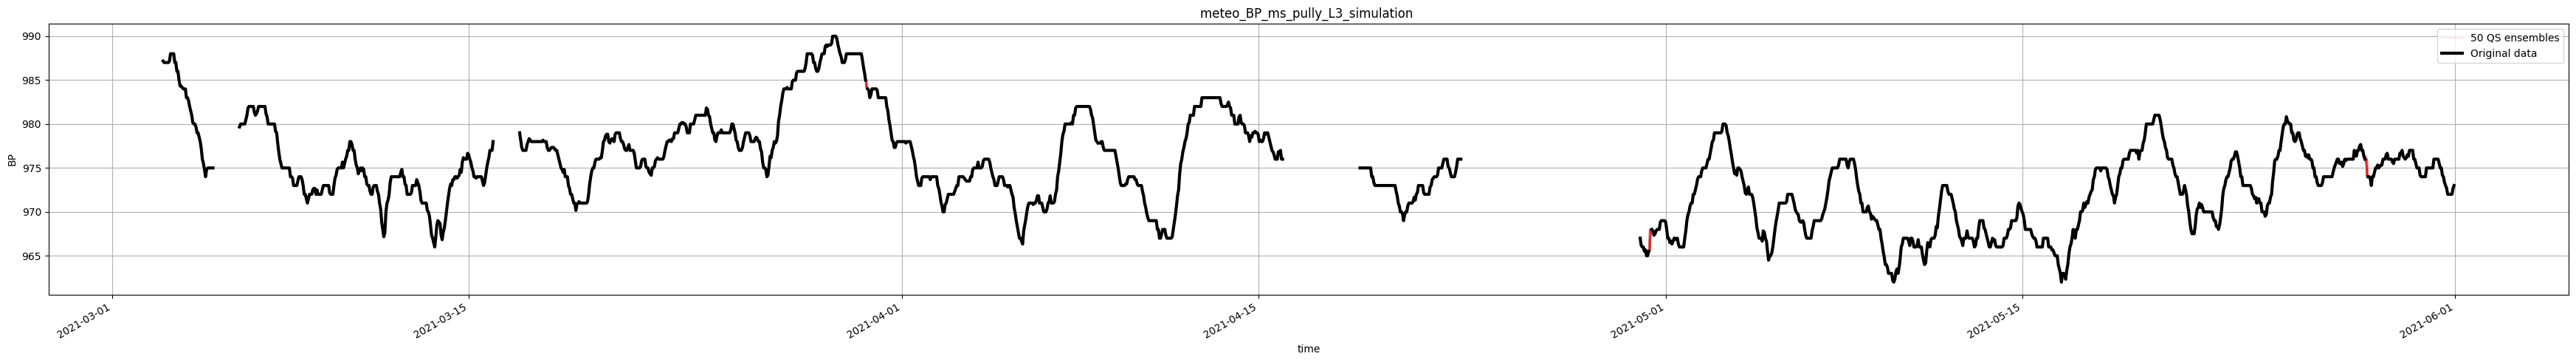

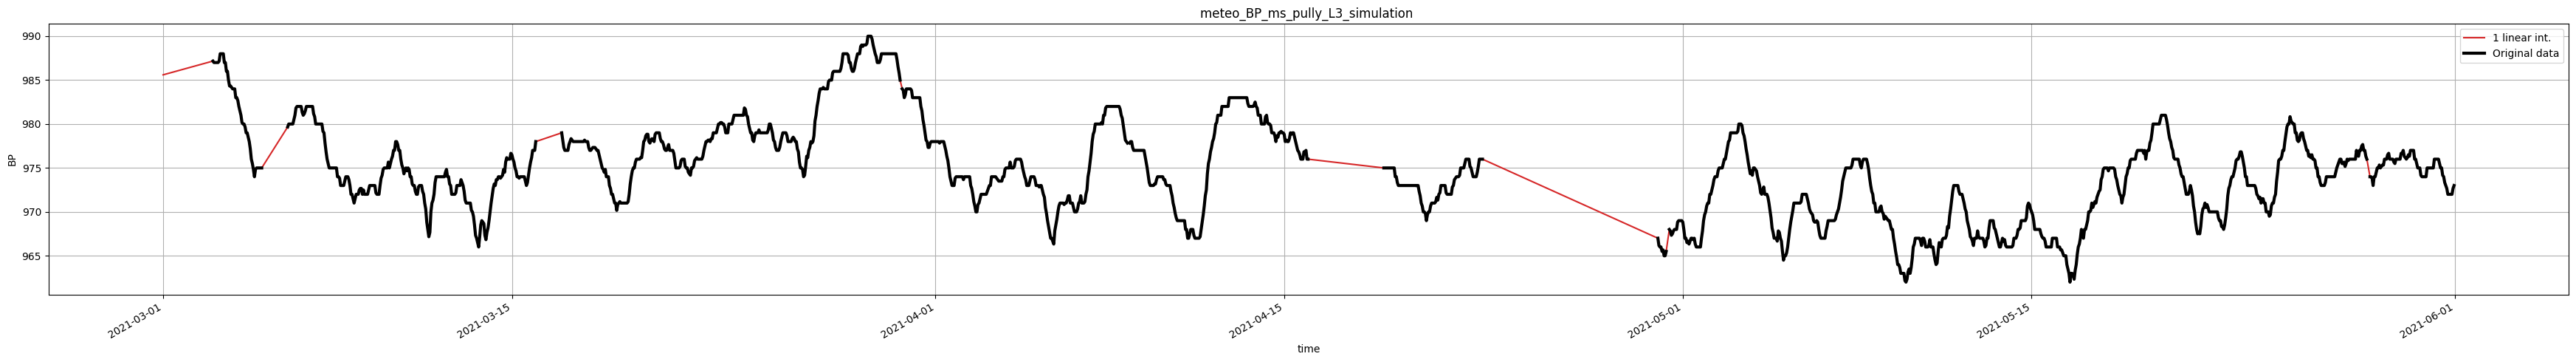

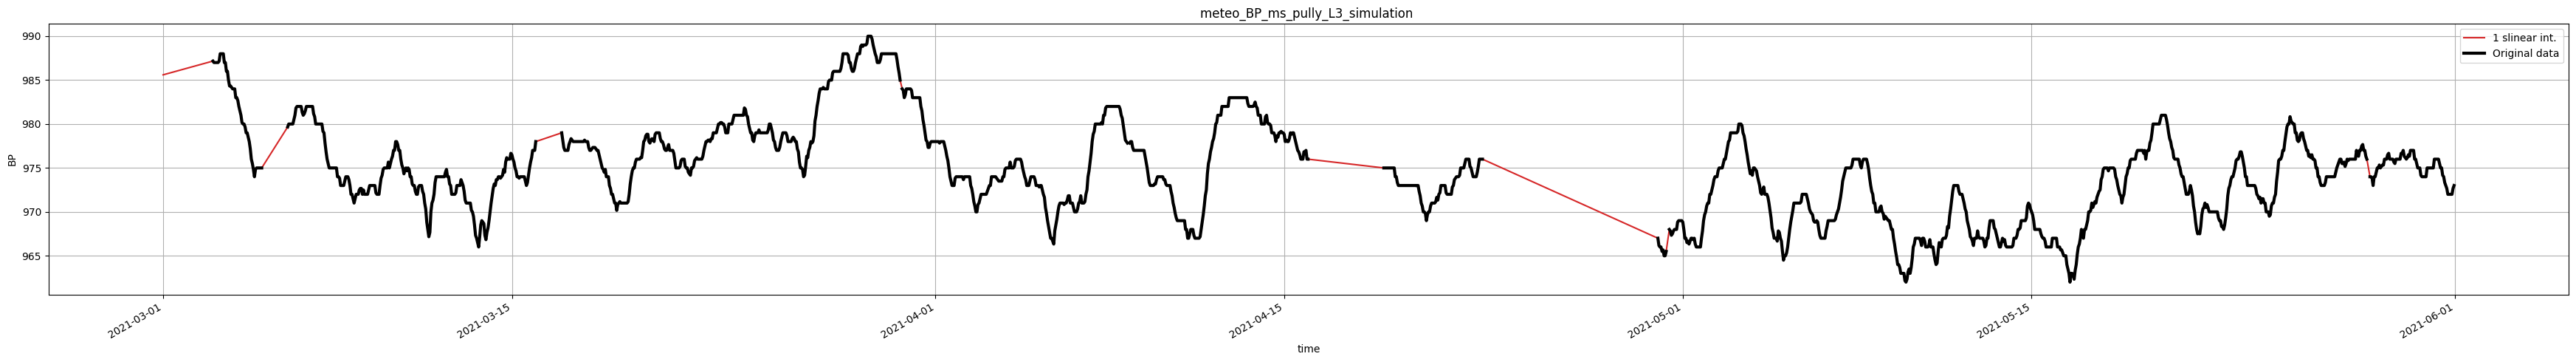

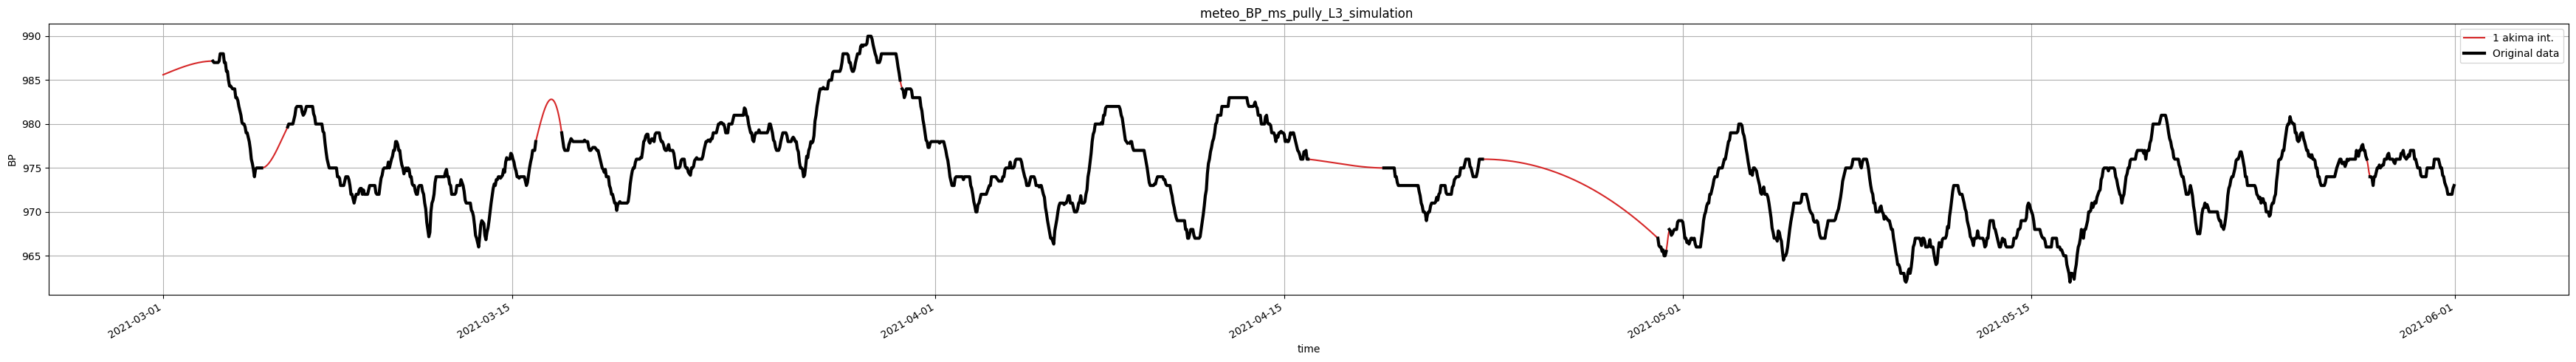

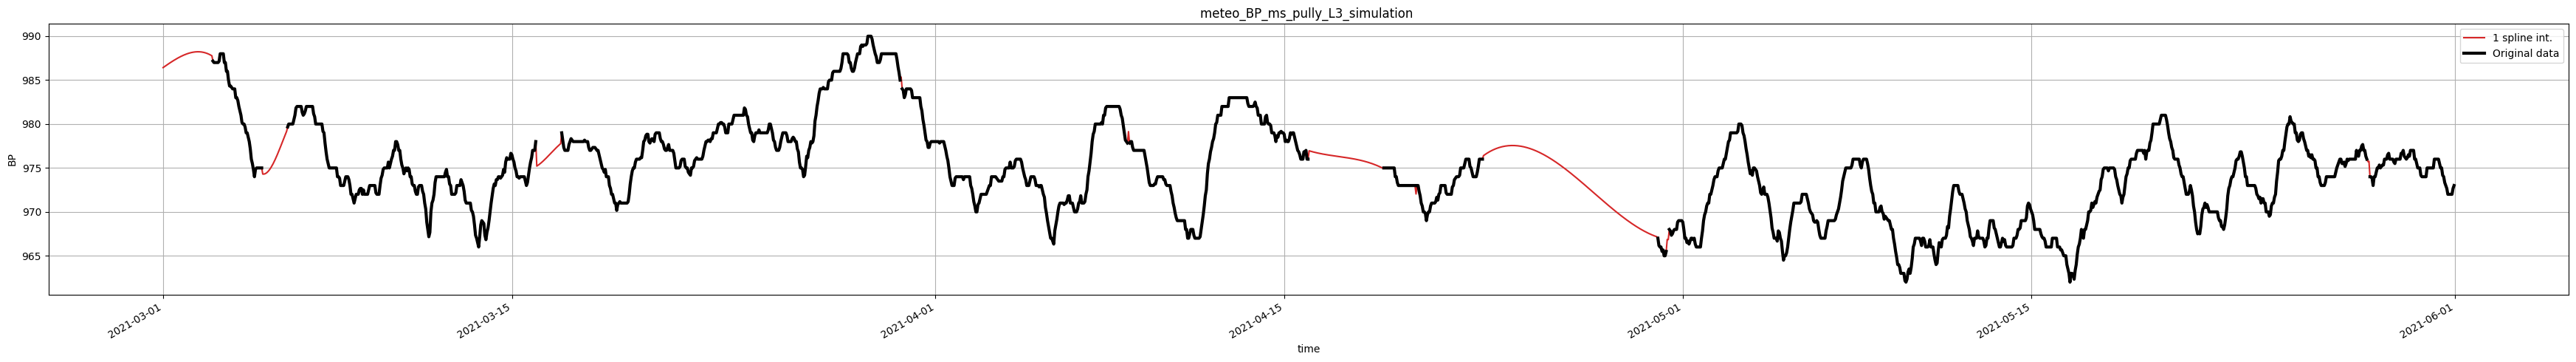

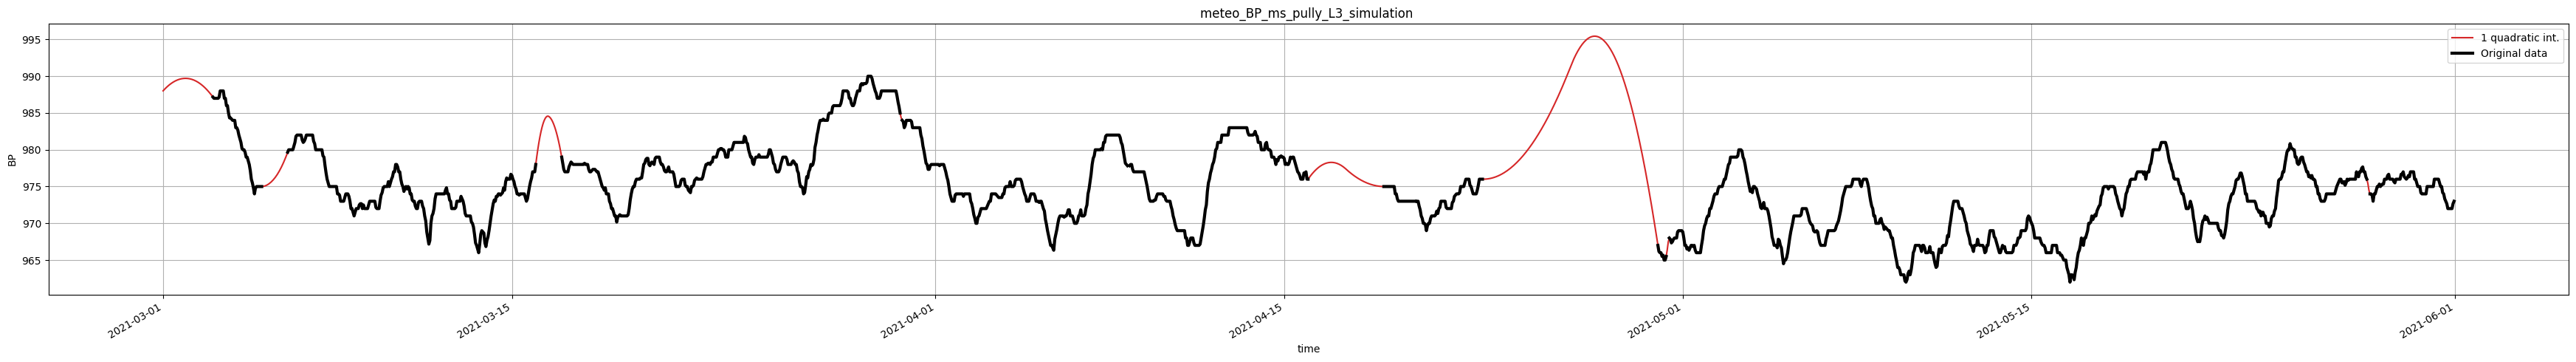

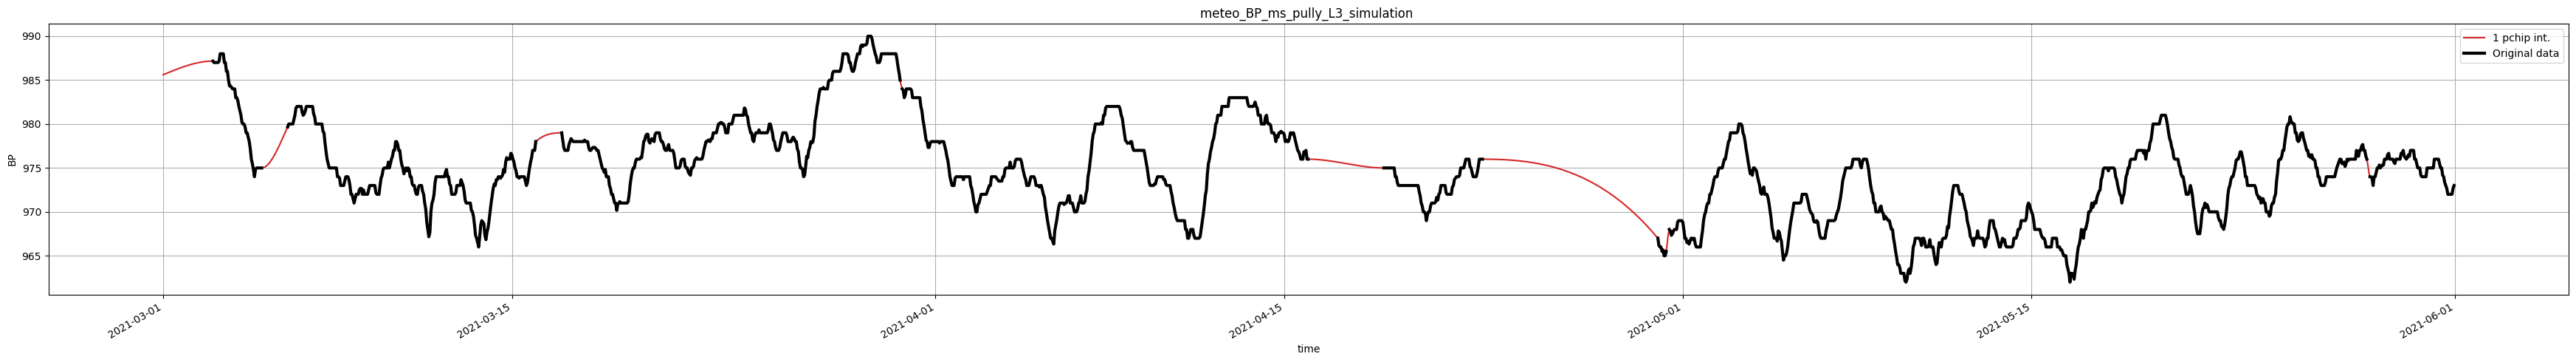

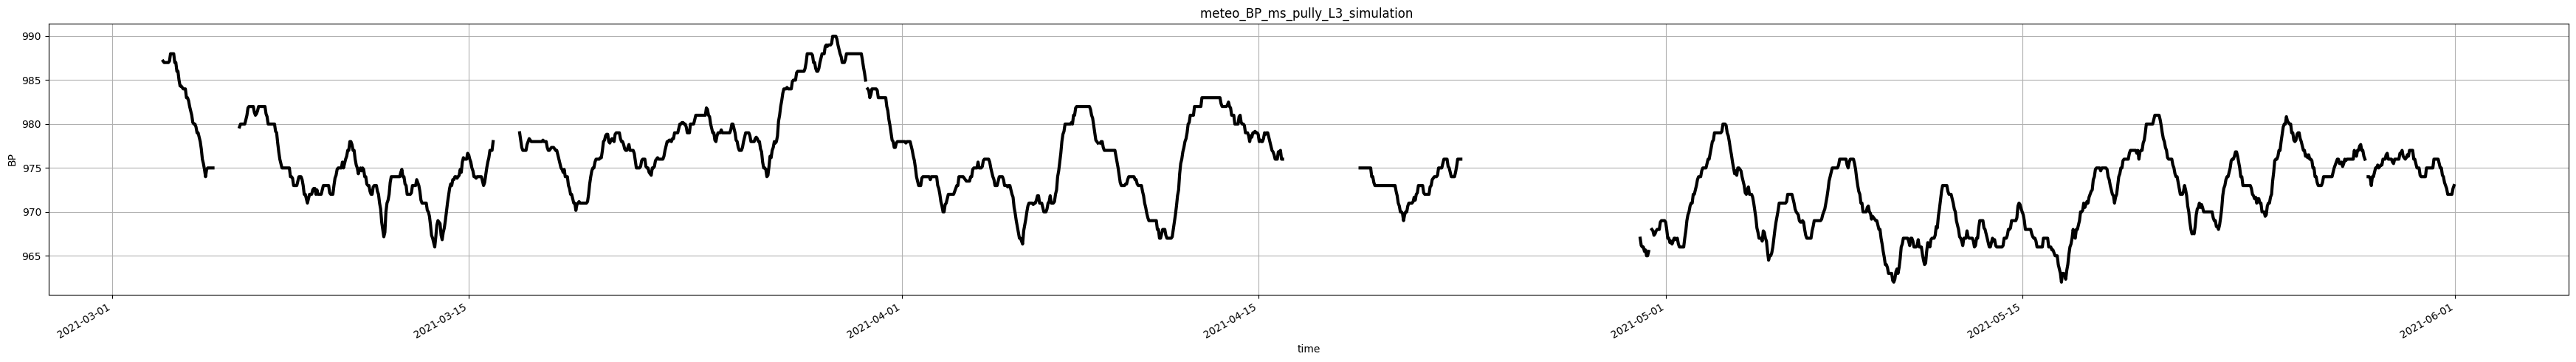

In [200]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [205]:
save_name="meteo_L3_"+varname+"_ms_pully_50member.nc"

L3_simulation.to_netcdf(recs_folder+save_name)

xr.open_dataset(recs_folder+save_name)

<xarray.Dataset>
Dimensions:       (realizations: 50, time: 26280)
Coordinates:
  * realizations  (realizations) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
  * time          (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    BP            (realizations, time) float32 ...

In [206]:
save_name="meteo_L4_"+varname+"_ms_pully_50member.nc"

L4_simulation.to_netcdf(recs_folder+save_name)

xr.open_dataset(recs_folder+save_name)

<xarray.Dataset>
Dimensions:       (realizations: 50, time: 26280)
Coordinates:
  * realizations  (realizations) int64 1 2 3 4 5 6 7 8 ... 44 45 46 47 48 49 50
  * time          (time) datetime64[ns] 2020-06-01 ... 2023-05-31T23:00:00
Data variables:
    BP            (realizations, time) float32 ...

## Fill Incoming Solar Radiation Data

### understand the average gap size in data

In [105]:
varname="Slrw"


meteo_orig_slrw has 934 nans in 26280 data points
meteo_orig_slrw has 3.55% missing values
meteo_orig_slrw has 77 gaps with 1.0 median gap size
meteo_orig_slrw has 77 gaps with 12.13 mean gap size


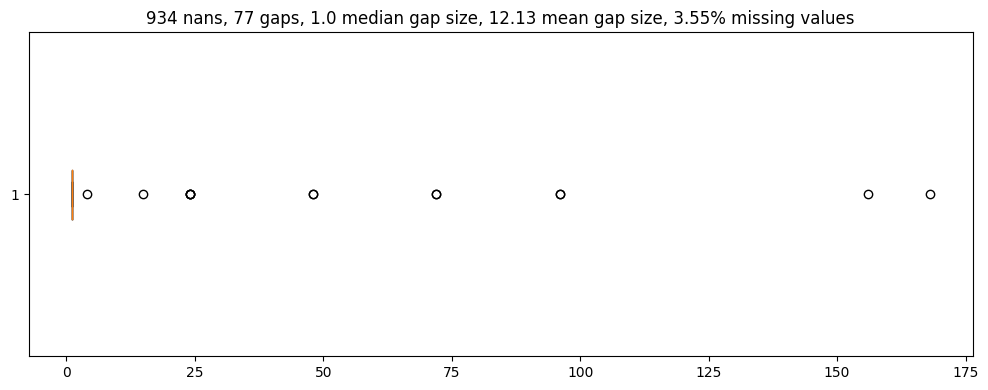

In [106]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_slrw",plot_folder=output_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
print(datetime.datetime.now())

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2="ssrd",cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rad",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2="ssrd",cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="GLOB",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
error_df

In [107]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")


In [ ]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

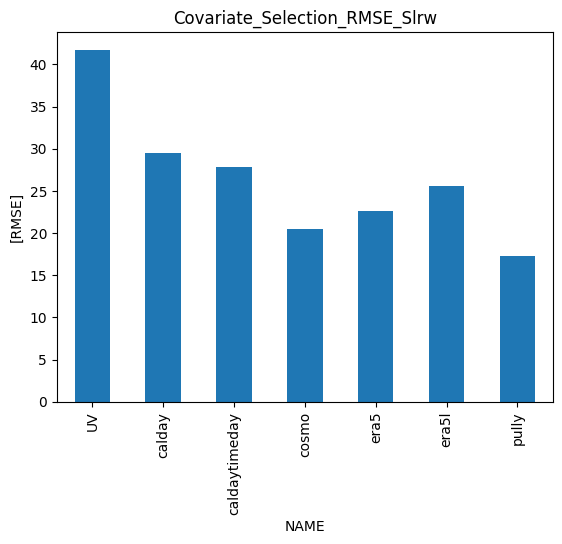

In [108]:
error_df.groupby('NAME').mean().RMSE.plot(kind="bar")
name="Covariate_Selection_RMSE_"+varname
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig(plots_folder+name+".png")

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rad",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rad",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rad",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
perc=error_df["PERC"].values
gap_size=error_df["GAP_SIZE"].values
rmse=error_df["RMSE"].values

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [ ]:
N = 50

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["ssrd"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["ssrd"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L3_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [ ]:
save_name="meteo_L3_"+varname+"_ms_pully_50member.nc"

L3_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

In [ ]:
save_name="meteo_L4_"+varname+"_ms_pully_50member.nc"

L4_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

## Fill Rainfall Data

### understand the average gap size in data

In [109]:
varname="Rain"


meteo_orig_rain has 929 nans in 26280 data points
meteo_orig_rain has 3.54% missing values
meteo_orig_rain has 72 gaps with 1.0 median gap size
meteo_orig_rain has 72 gaps with 12.9 mean gap size


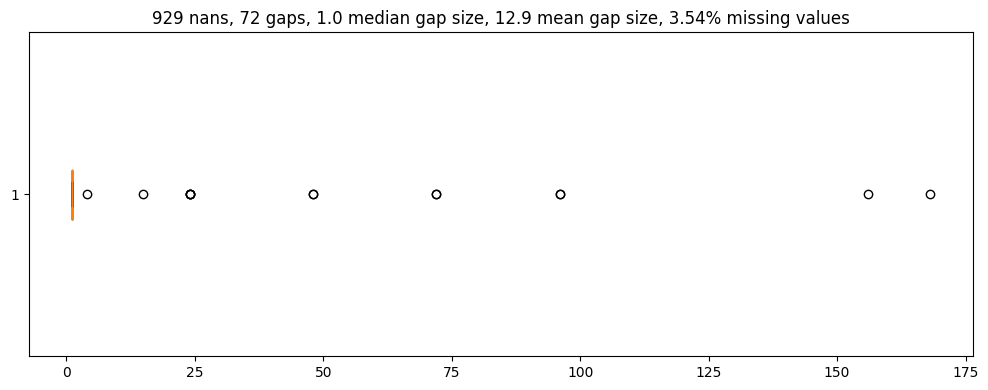

In [110]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_rain",plot_folder=output_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
print(datetime.datetime.now())

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="precip",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2="tp",cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:

filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2="tp",cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="TOT_PREC",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
error_df

In [111]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")

In [113]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

RUN  MEMBER  PERC     CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE                                                                  
24        5.5    25.0   5.0  0.92742   0.93346     0.93300      0.93475   
48        5.5    25.0   5.0  0.91705   0.92838     0.92805      0.92916   
72        5.5    25.0   5.0  0.92727   0.93412     0.92501      0.93471   

          CORR_quad  CORR_pchip  CORR_subdlin     RMSE  RMSE_lin  RMSE_akima  \
GAP_SIZE                                                                       
24          0.89111     0.93333       0.92309  0.04781   0.03876     0.03975   
48          0.79700     0.92846       0.92735  0.05861   0.03934     0.04009   
72          0.86555     0.93402       0.93369  0.04686   0.03736     0.04918   

          RMSE_spline  RMSE_quad  RMSE_pchip  RMSE_subdlin          STDR  
GAP_SIZE                                                                  
24            0.03545    0.08165     0.03912       0.04761 -1.985648e+07  
48            0.03807    0.13399     0.03933       0.04173 -1.731031e+06  
72            0.03567    0.09982     0.03760       0.03833 -2.257874e+05

In [114]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

RUN  MEMBER  PERC     CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE                                                                  
24        5.5    25.0   5.0  0.99231   0.99563     0.99514      0.99616   
48        5.5    25.0   5.0  0.92661   0.93617     0.93419      0.93691   
72        5.5    25.0   5.0  0.99712   0.99696     0.99249      0.99800   

          CORR_quad  CORR_pchip  CORR_subdlin     RMSE  RMSE_lin  RMSE_akima  \
GAP_SIZE                                                                       
24          0.95808     0.99560       0.98547  0.02452   0.01840     0.01966   
48          0.85807     0.93612       0.93477  0.04776   0.03452     0.03870   
72          0.80941     0.99700       0.99573  0.01668   0.01675     0.02289   

          RMSE_spline  RMSE_quad  RMSE_pchip  RMSE_subdlin         STDR  
GAP_SIZE                                                                 
24            0.01659    0.06425     0.01841       0.02929 -91092.82026  
48            0.03265    0.10205     0.03456       0.03724 -42965.48357  
72            0.01381    0.16399     0.01649       0.01957 -27177.12419

In [115]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

RUN  MEMBER  PERC     CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE                                                                  
24        5.5    25.0   5.0  0.91677   0.93608     0.93526      0.93652   
48        5.5    25.0   5.0  0.92579   0.93415     0.93323      0.93558   
72        5.5    25.0   5.0  0.98252   0.99603     0.99464      0.99672   

          CORR_quad  CORR_pchip  CORR_subdlin     RMSE  RMSE_lin  RMSE_akima  \
GAP_SIZE                                                                       
24          0.88158     0.93599       0.92560  0.06183   0.03317     0.03541   
48          0.87020     0.93399       0.93203  0.05241   0.03780     0.03986   
72          0.84501     0.99582       0.99628  0.04266   0.01822     0.02112   

          RMSE_spline  RMSE_quad  RMSE_pchip  RMSE_subdlin          STDR  
GAP_SIZE                                                                  
24            0.03245    0.08931     0.03334       0.04585 -6.146290e+05  
48            0.03412    0.09714     0.03811       0.04245 -1.787659e+06  
72            0.01617    0.13604     0.01871       0.01748 -2.859093e+06

In [116]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

RUN  MEMBER  PERC     CORR  CORR_lin  CORR_akima  CORR_spline  \
GAP_SIZE                                                                  
24        5.5    25.0   5.0  0.92681   0.93630     0.93541      0.93678   
48        5.5    25.0   5.0  0.98967   0.99760     0.99754      0.99812   
72        5.5    25.0   5.0  0.91863   0.93647     0.93622      0.93652   

          CORR_quad  CORR_pchip  CORR_subdlin     RMSE  RMSE_lin  RMSE_akima  \
GAP_SIZE                                                                       
24          0.88322     0.93621       0.92590  0.04986   0.03373     0.03618   
48          0.93695     0.99755       0.97863  0.03258   0.01511     0.01531   
72          0.80804     0.93647       0.90812  0.05907   0.03344     0.03423   

          RMSE_spline  RMSE_quad  RMSE_pchip  RMSE_subdlin          STDR  
GAP_SIZE                                                                  
24            0.03192    0.08648     0.03400       0.04527  2.579599e+06  
48            0.01347    0.07401     0.01522       0.03288  1.336078e+06  
72            0.03344    0.13118     0.03346       0.05422 -5.812430e+07

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

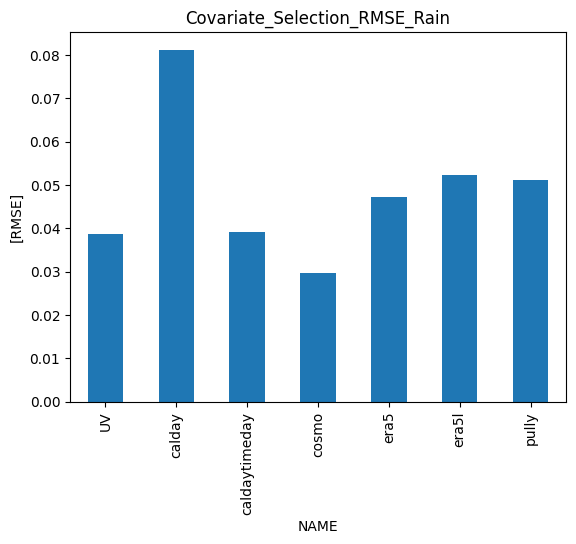

In [112]:
error_df.groupby('NAME').mean().RMSE.plot(kind="bar")
name="Covariate_Selection_RMSE_"+varname
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig(plots_folder+name+".png")

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="TOT_PREC",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_cosmo_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="TOT_PREC",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_cosmo_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="TOT_PREC",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_cosmo_",vario=True)

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
perc=error_df["PERC"].values
gap_size=error_df["GAP_SIZE"].values
rmse=error_df["RMSE"].values

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [ ]:
N = 50

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["tp"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["tp"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L3_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [ ]:
save_name="meteo_L3_"+varname+"_ms_pully_50member.nc"

L3_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

In [ ]:
save_name="meteo_L4_"+varname+"_ms_pully_50member.nc"

L4_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

## Fill Wind Direction Data

### understand the average gap size in data

In [117]:
varname="WindDir"

meteo_orig_winddir has 929 nans in 26280 data points
meteo_orig_winddir has 3.54% missing values
meteo_orig_winddir has 72 gaps with 1.0 median gap size
meteo_orig_winddir has 72 gaps with 12.9 mean gap size


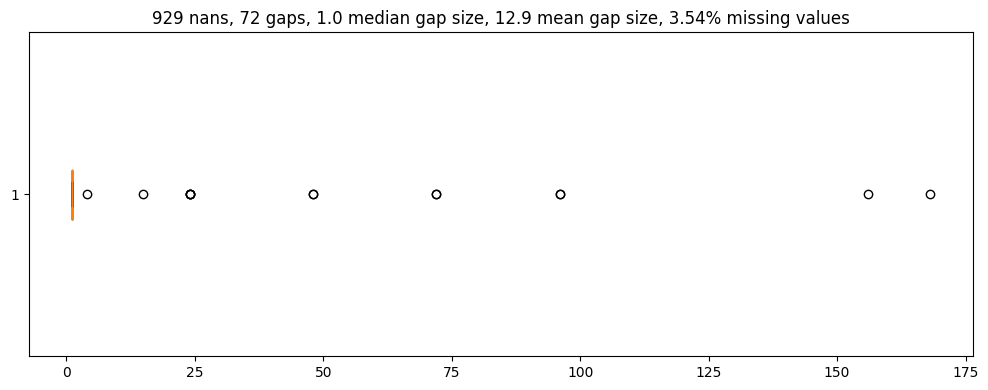

In [118]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_winddir",plot_folder=output_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="wd",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2="wd",cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2="wd",cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="WD",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [119]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")

In [ ]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

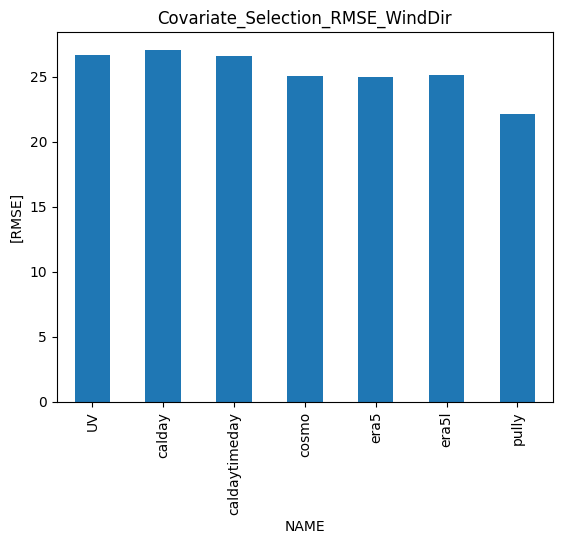

In [120]:
error_df.groupby('NAME').mean().RMSE.plot(kind="bar")
name="Covariate_Selection_RMSE_"+varname
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig(plots_folder+name+".png")

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="wd",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="wd",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="wd",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
perc=error_df["PERC"].values
gap_size=error_df["GAP_SIZE"].values
rmse=error_df["RMSE"].values

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [ ]:
N = 50

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["wd"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["wd"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L3_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [ ]:
save_name="meteo_L3_"+varname+"_ms_pully_50member.nc"

L3_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

In [ ]:
save_name="meteo_L4_"+varname+"_ms_pully_50member.nc"

L4_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

## Fill Wind Speed Data

### understand the average gap size in data

In [121]:
varname="WS"

meteo_orig_ws has 929 nans in 26280 data points
meteo_orig_ws has 3.54% missing values
meteo_orig_ws has 72 gaps with 1.0 median gap size
meteo_orig_ws has 72 gaps with 12.9 mean gap size


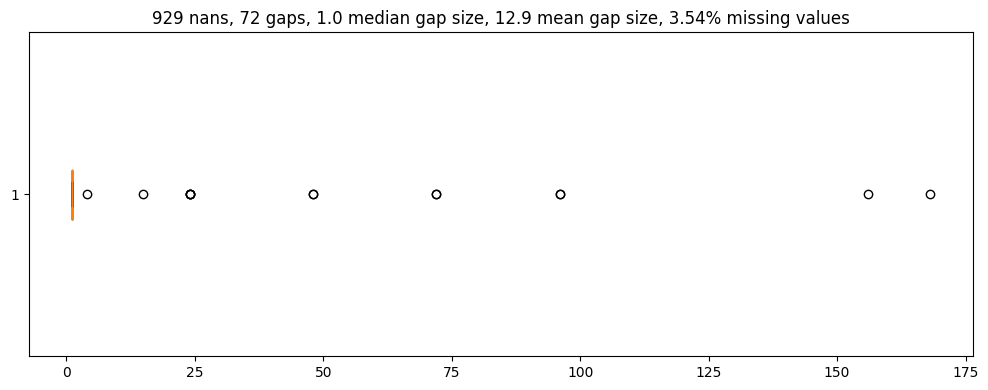

In [122]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_ws",plot_folder=output_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="ws",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2="ws",cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2="ws",cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="WS",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [123]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")

In [ ]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

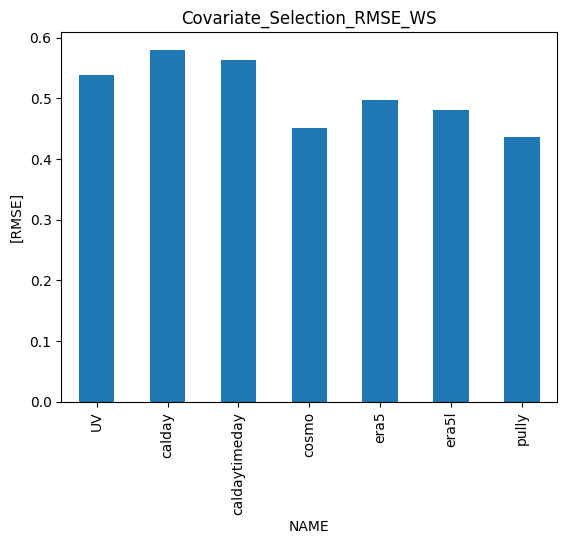

In [124]:
error_df.groupby('NAME').mean().RMSE.plot(kind="bar")
name="Covariate_Selection_RMSE_"+varname
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig(plots_folder+name+".png")

#### error matrix phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="ws",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="ws",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="ws",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [ ]:
N = 50

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["ws"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["ws"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L3_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [ ]:
save_name="meteo_L3_"+varname+"_ms_pully_50member.nc"

L3_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

In [ ]:
save_name="meteo_L4_"+varname+"_ms_pully_50member.nc"

L4_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

## Fill Relative Humidity Data

### understand the average gap size in data

In [125]:
varname="RH"

meteo_orig_rh has 931 nans in 26280 data points
meteo_orig_rh has 3.54% missing values
meteo_orig_rh has 73 gaps with 1.0 median gap size
meteo_orig_rh has 73 gaps with 12.75 mean gap size


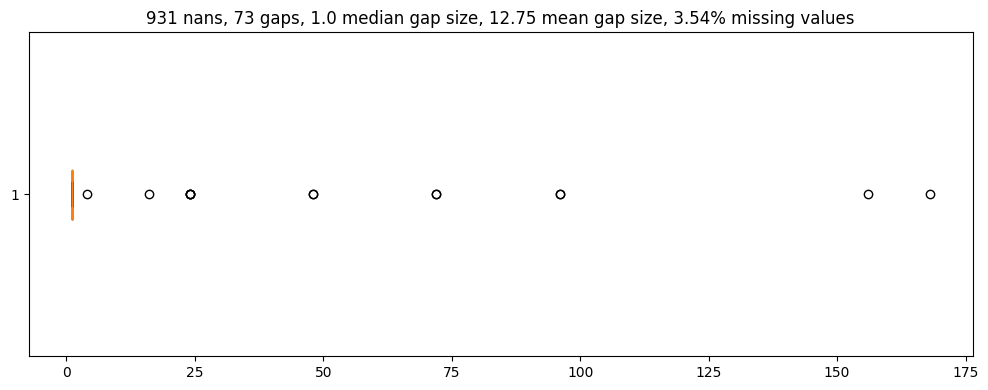

In [126]:
gap_info(var=meteo_orig[varname],varname="meteo_orig_rh",plot_folder=output_folder)

### Run gapfilling

#### eval phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72]
selector_list=[1,2,3]
#gap_amount_list=[150]
N = 25
test_runs=10

columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_subdlin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=univ_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=time_of_day_of_year_g2s(original=meteo_orig,var=varname,obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rh",cov_name="pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=two_cov_g2s(original=meteo_orig,var1=varname,cov=era5,var2=["t2m","tp"],cov_name="era5",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=two_cov_g2s(original=meteo_orig,var1=varname,cov=era5_land,var2=["t2m","tp"],cov_name="era5l",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=cosmo,var2="RELHUM_2M",cov_name="cosmo",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_eval_")

In [127]:
error_df=pd.read_csv(output_folder+"meteo_eval_"+varname+".csv")

In [ ]:
error_df[error_df.NAME =="pully"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="cosmo"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5l"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="era5"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="UV"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="calday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

In [ ]:
error_df[error_df.NAME =="caldaytimeday"][error_df.columns[1:]].groupby('GAP_SIZE').mean()

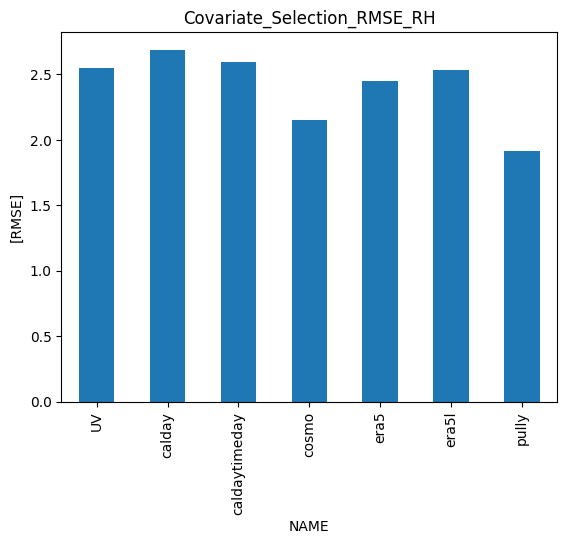

In [128]:
error_df.groupby('NAME').mean().RMSE.plot(kind="bar")
name="Covariate_Selection_RMSE_"+varname
plt.ylabel("[RMSE]")
plt.title(name)
plt.savefig(plots_folder+name+".png")

#### error phase

In [ ]:
percent_list=[5]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rh",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[10]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rh",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
percent_list=[15]
gap_amount_list=[24,48,72,96,120,144]
selector_list=[1,2,3,4,5,6]
#gap_amount_list=[150]
N = 25
test_runs=5


columns_df=["NAME",'RUN',"MEMBER","PERC","GAP_SIZE","CORR","CORR_lin","CORR_akima","CORR_spline","CORR_quad","CORR_pchip","CORR_sublin","RMSE","RMSE_lin","RMSE_akima","RMSE_spline","RMSE_quad","RMSE_pchip","RMSE_sublin","RMSE_VAR_ensmean","RMSE_VAR_ensmed","RMSE_VAR_linear","RMSE_VAR_akima","RMSE_VAR_spline","RMSE_VAR_quad","RMSE_VAR_pchip","RMSE_VAR_subdlin","STDR"]

df = pd.DataFrame(columns=columns_df)

In [ ]:
filled_data,error_df=one_cov_g2s(original=meteo_orig,var1=varname,cov=ms_pully,var2="rh",cov_name="ms_pully",obs_in_day=24,N=N,percent_list=percent_list,gap_amount_list=gap_amount_list,selector_list=selector_list,test_runs=test_runs,df=df,csv_folder=output_folder,name="meteo_ms_pully_",vario=True)

In [ ]:
error_df=pd.read_csv(output_folder+"meteo_ms_pully_"+varname+".csv")


In [ ]:
error_df[error_df.columns[1:]].groupby(['GAP_SIZE',"PERC"]).mean()

In [ ]:
perc=error_df["PERC"].values
gap_size=error_df["GAP_SIZE"].values
rmse=error_df["RMSE"].values

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='RMSE')
plt.show()

In [ ]:
import seaborn as sns
sns.relplot(data=error_df, x='PERC', y='GAP_SIZE', hue='CORR')
plt.show()

In [ ]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
z = rmse
x = gap_size
y = perc
 
# plotting
ax.plot3D(x, y, z, '.b')
ax.set_title('3D line plot geeks for geeks')
plt.show()

#### reconstruction phase

In [ ]:
N = 50

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["rh"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L4_stacked = ensemble_QS(N = N,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L4_simulation = xr.DataArray(data =L4_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L4_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
#gap-filling with one covariate
covar2 = ms_pully["rh"].copy()
#name_addedinfo=cov_name
#covar2.loc[dict(time = covar2.time[gap_indices])] = np.nan
gapped_data=meteo_orig[varname].copy()

ti = np.stack([gapped_data.data,
            covar2],axis = 1)
di = np.stack([gapped_data.data,
            covar2],axis = 1)
dt = [0,0,] 
sp=generate_simulation_path_wo_gaps(gapped_data,max_timesteps_tofill)
#ki = np.ones([L,5])
#ki[:,:4] = 0.3 #Assign half weight to categorical variable 


L3_stacked = ensemble_QS(N = N,sp=sp,
                      ti=ti, 
                      di=di,
                      dt=dt, #Zero for continuous variables
                      k=1.2,
                      n=50,
                      j=0.5,
                      ki=None)
L3_simulation = xr.DataArray(data =L3_stacked[:,:,0],
                            coords = {'realizations':np.arange(1,L3_stacked.shape[0]+1),'time':gapped_data.time},name=varname)

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L4_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L4_simulation")

In [ ]:
year = 2021
start_month =3
end_month = 5

plot_MPS_ensembles(original = gapped_data,
                   simulation = L3_simulation, 
                   year = year,
                   start_month = start_month,
                   end_month = end_month,plot_folder=output_folder,
                  alpha = 0.1,
                  title = "meteo_"+varname+"_ms_pully_L3_simulation")

In [ ]:
save_name="meteo_L3_"+varname+"_ms_pully_50member.nc"

L3_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)

In [ ]:
save_name="meteo_L4_"+varname+"_ms_pully_50member.nc"

L4_simulation.to_netcdf(output_folder+save_name)

xr.open_dataset(output_folder+save_name)